# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [13]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.77'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [15]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=False
prefix_str=' '

# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)


In [16]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['Ne1.txt',
 'Ne10.txt',
 'Ne11.txt',
 'Ne12.txt',
 'Ne13.txt',
 'Ne14.txt',
 'Ne15.txt',
 'Ne16.txt',
 'Ne17.txt',
 'Ne18.txt',
 'Ne19.txt',
 'Ne2.txt',
 'Ne20.txt',
 'Ne21.txt',
 'Ne22.txt',
 'Ne23.txt',
 'Ne24.txt',
 'Ne25.txt',
 'Ne26.txt',
 'Ne3.txt',
 'Ne4.txt',
 'Ne5.txt',
 'Ne6.txt',
 'Ne7.txt',
 'Ne8.txt',
 'Ne9.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [17]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           818.699523     5000.0                556.27662
9          1117.086987     5000.0                565.66588
16         1310.480205     5000.0                571.92248
19         1398.915133     5000.0                574.82985
23         1447.564622     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [18]:
line_1=1219
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=100)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  227.457159  1220.107463  1447.564622                1219   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [19]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height  Peak1_prom  \
0  1219.691051        3027.0  1447.663174   38163.33203      2306.0   

    Peak2_prom  
0  37442.33203

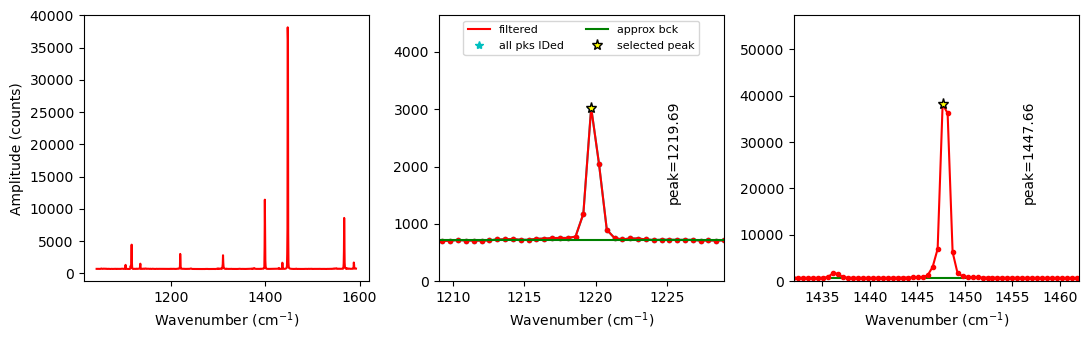

In [20]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [21]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [22]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=1, 
pk1_sigma=0.6, lower_bck_pk1=(-40, -20), upper_bck1_pk1=[30, 50], upper_bck2_pk1=[30, 50],
pk2_sigma=0.6, lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )



filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  pk2_amplitude  \
0  Ne1.txt         0.000019    0.000019    1447.912721    49263.93372   

   pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_peak_cent  ...  \
0    0.41171      None    0.00181        0.386932    1219.842547  ...   

   pk1_gamma  error_pk1 Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0       None   0.003903       0.503905  228.070174  0.997312     0.997287   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0     0.997337     104.24112     16.168624        120.409744  

[1 rows x 22 columns]

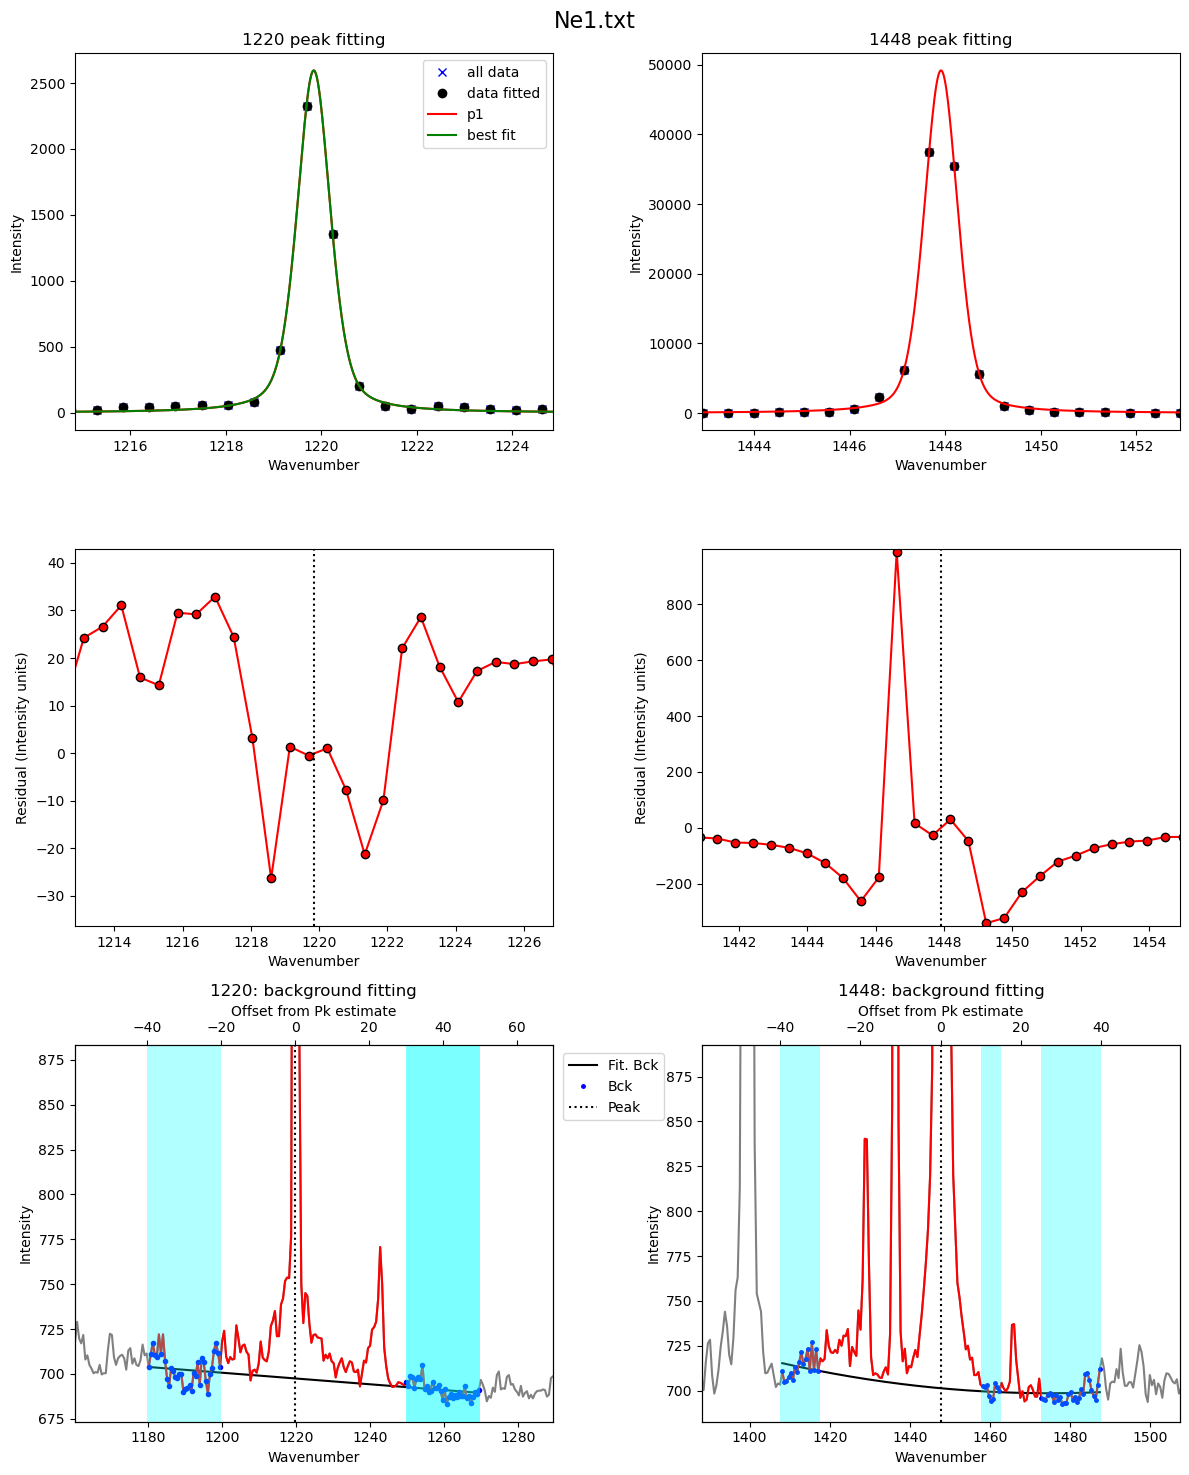

In [23]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [24]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/26 [00:00<?, ?it/s]

c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\ne_lines.py:1220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ((ax3, ax2), (ax5, ax4), (ax1, ax0)) = plt.subplots(3,2, figsize = (12,15)) # adjust dimensions of figure here


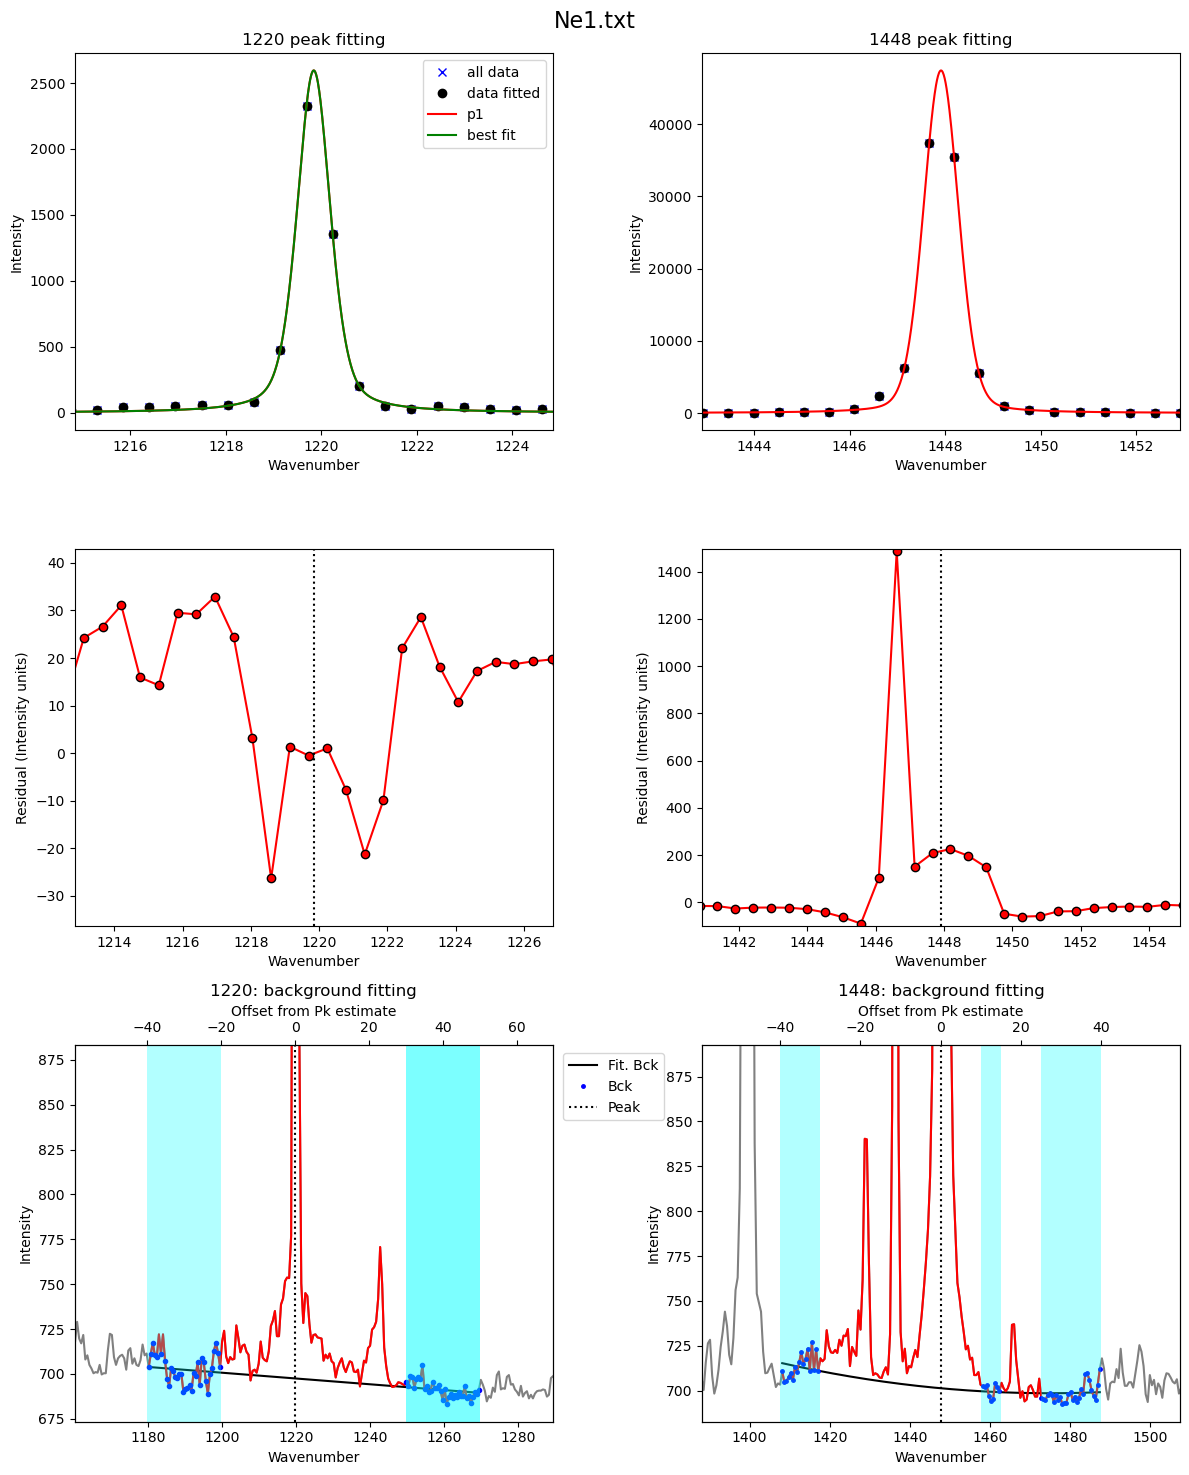

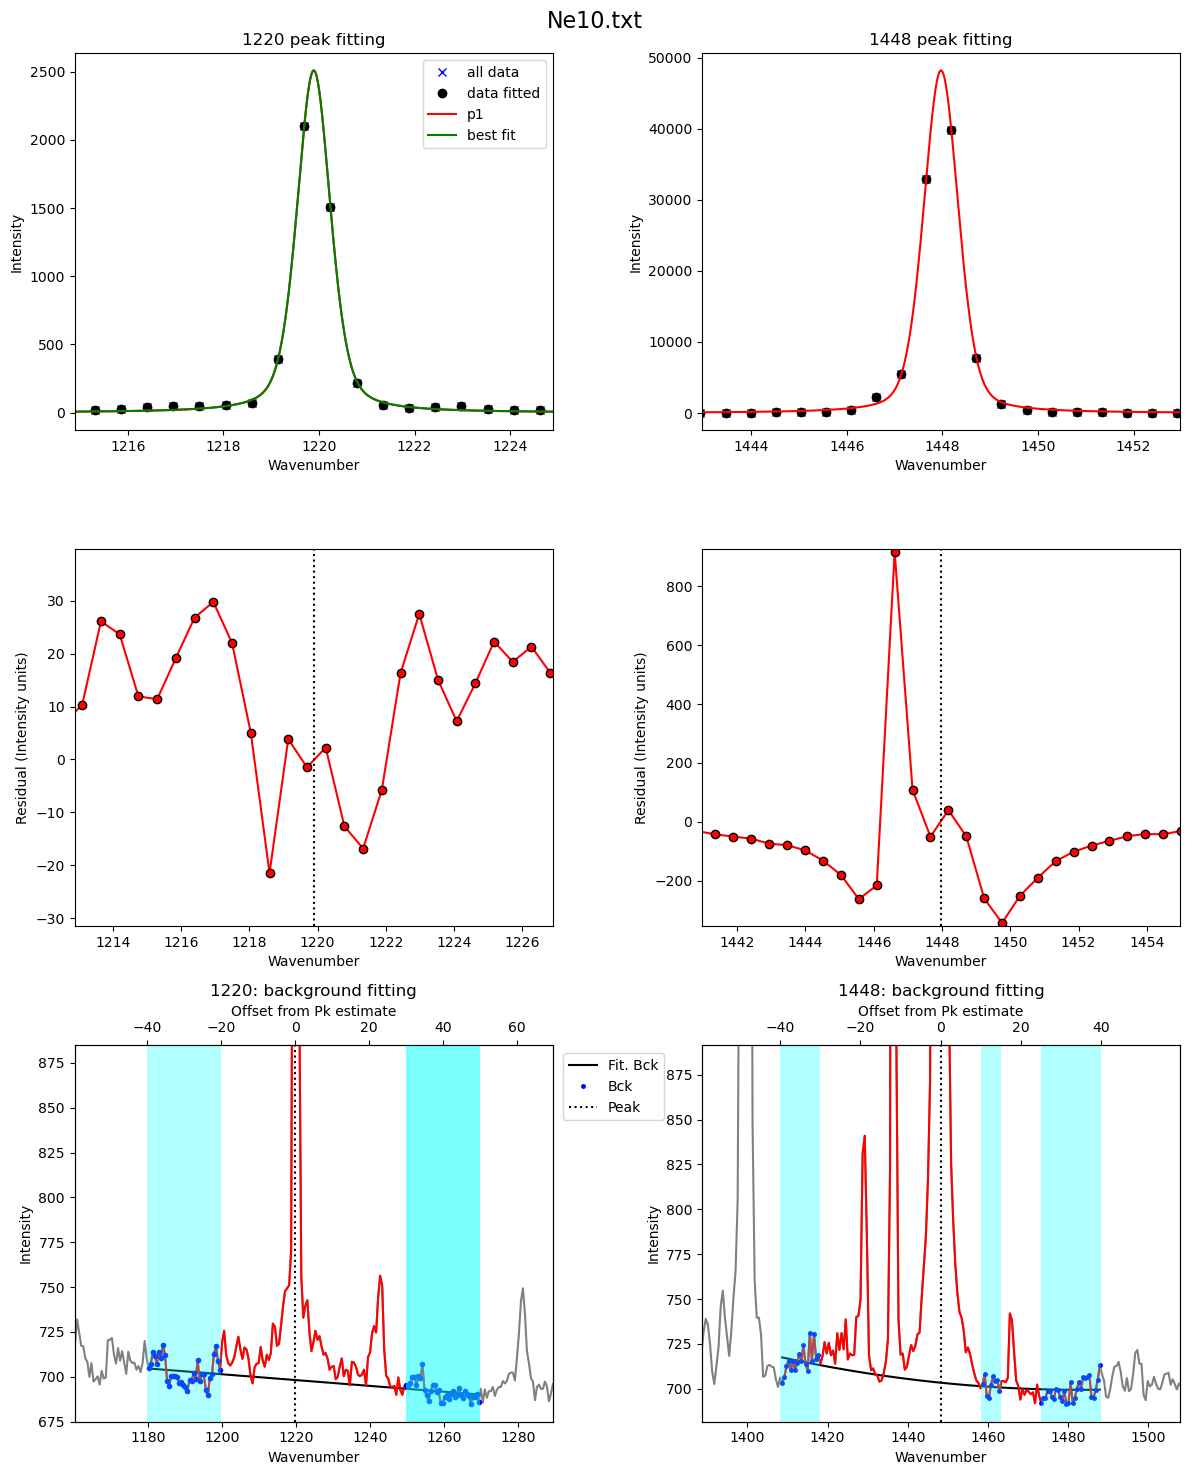

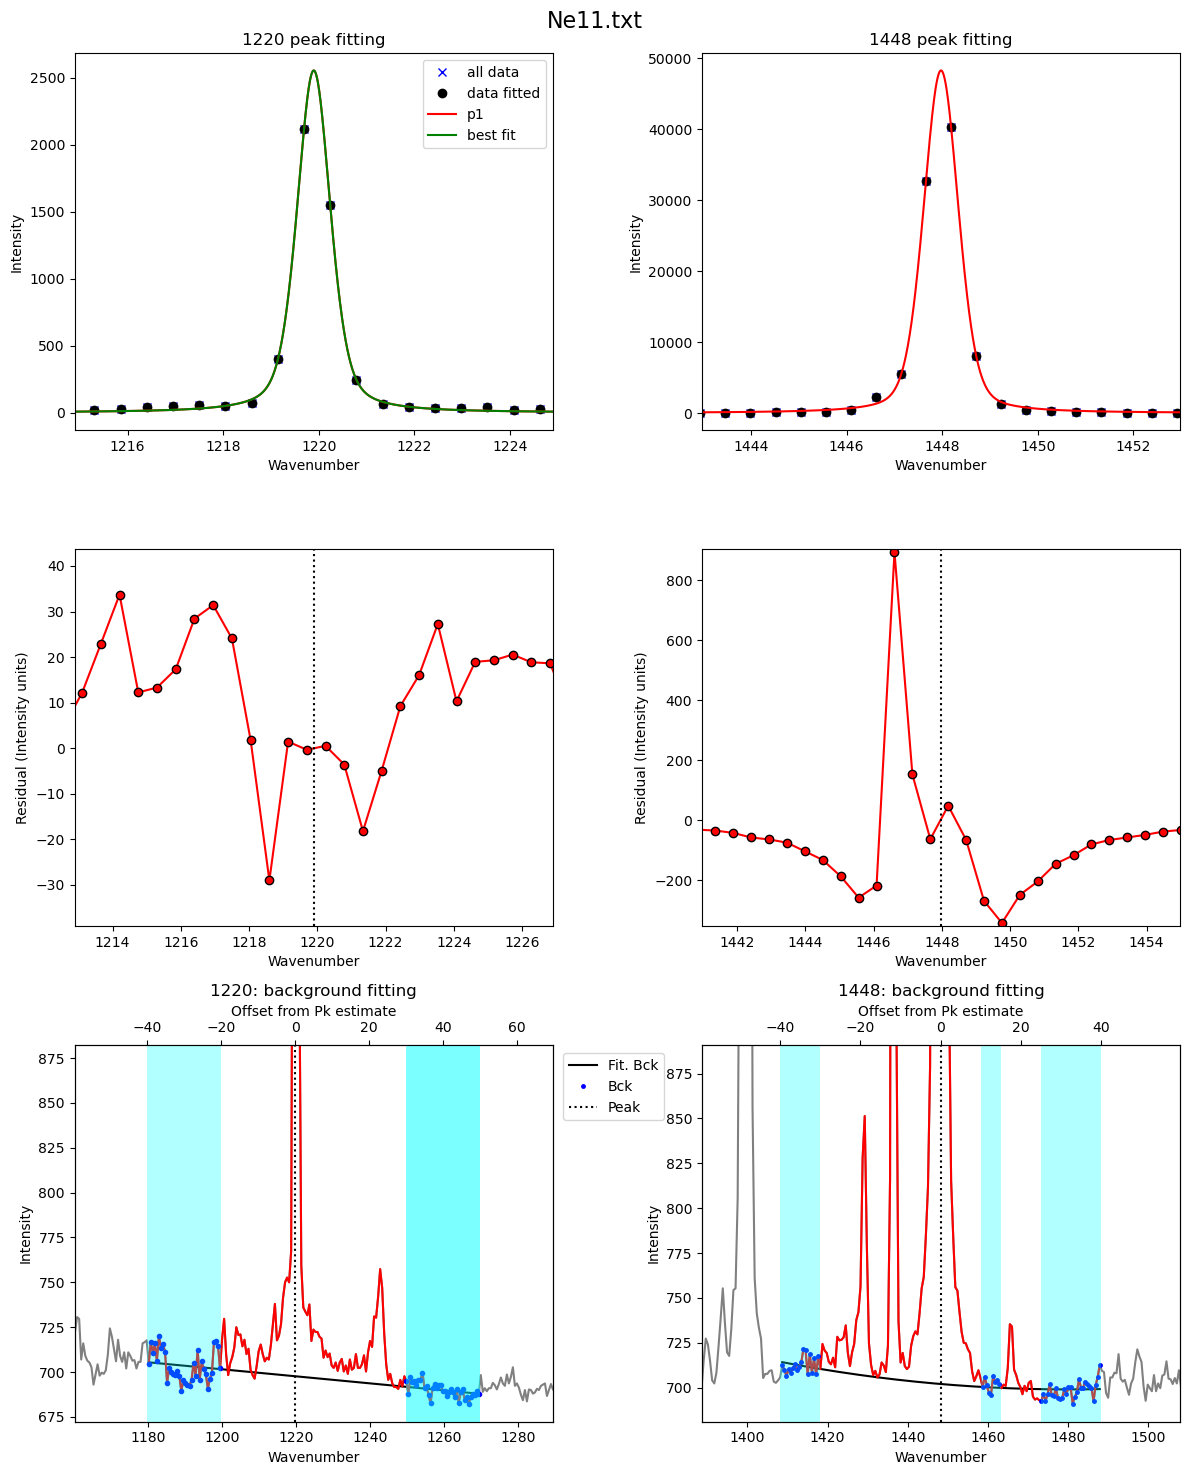

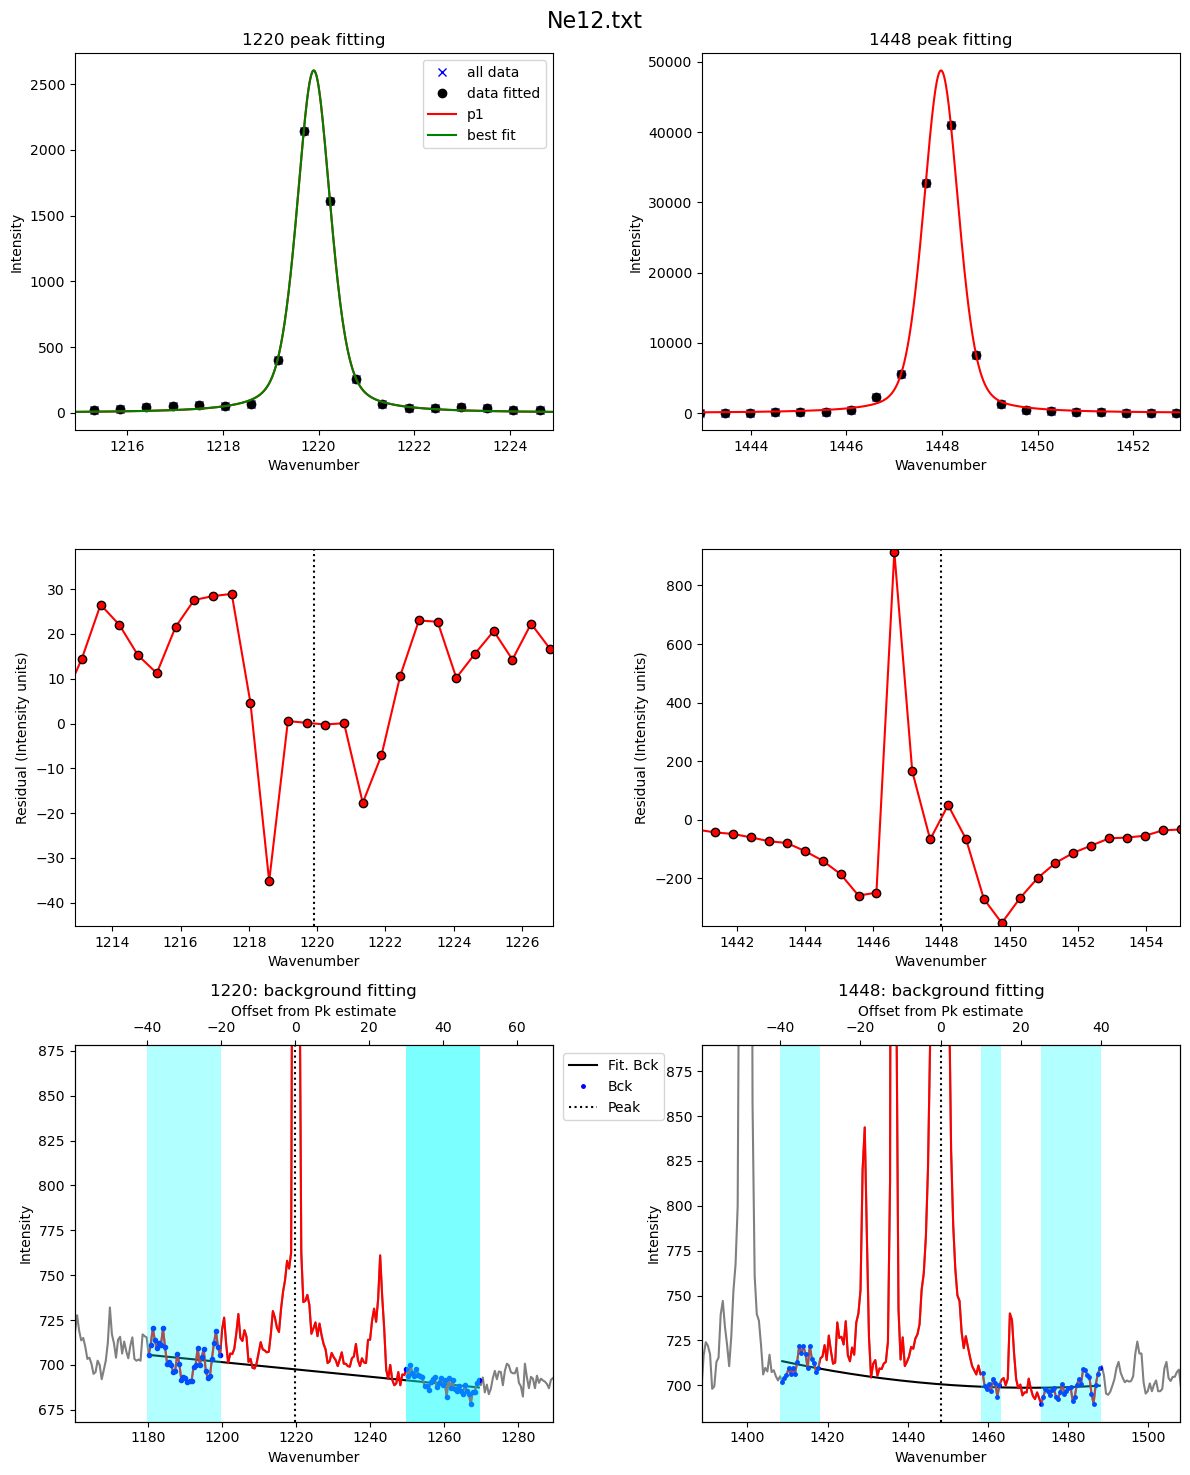

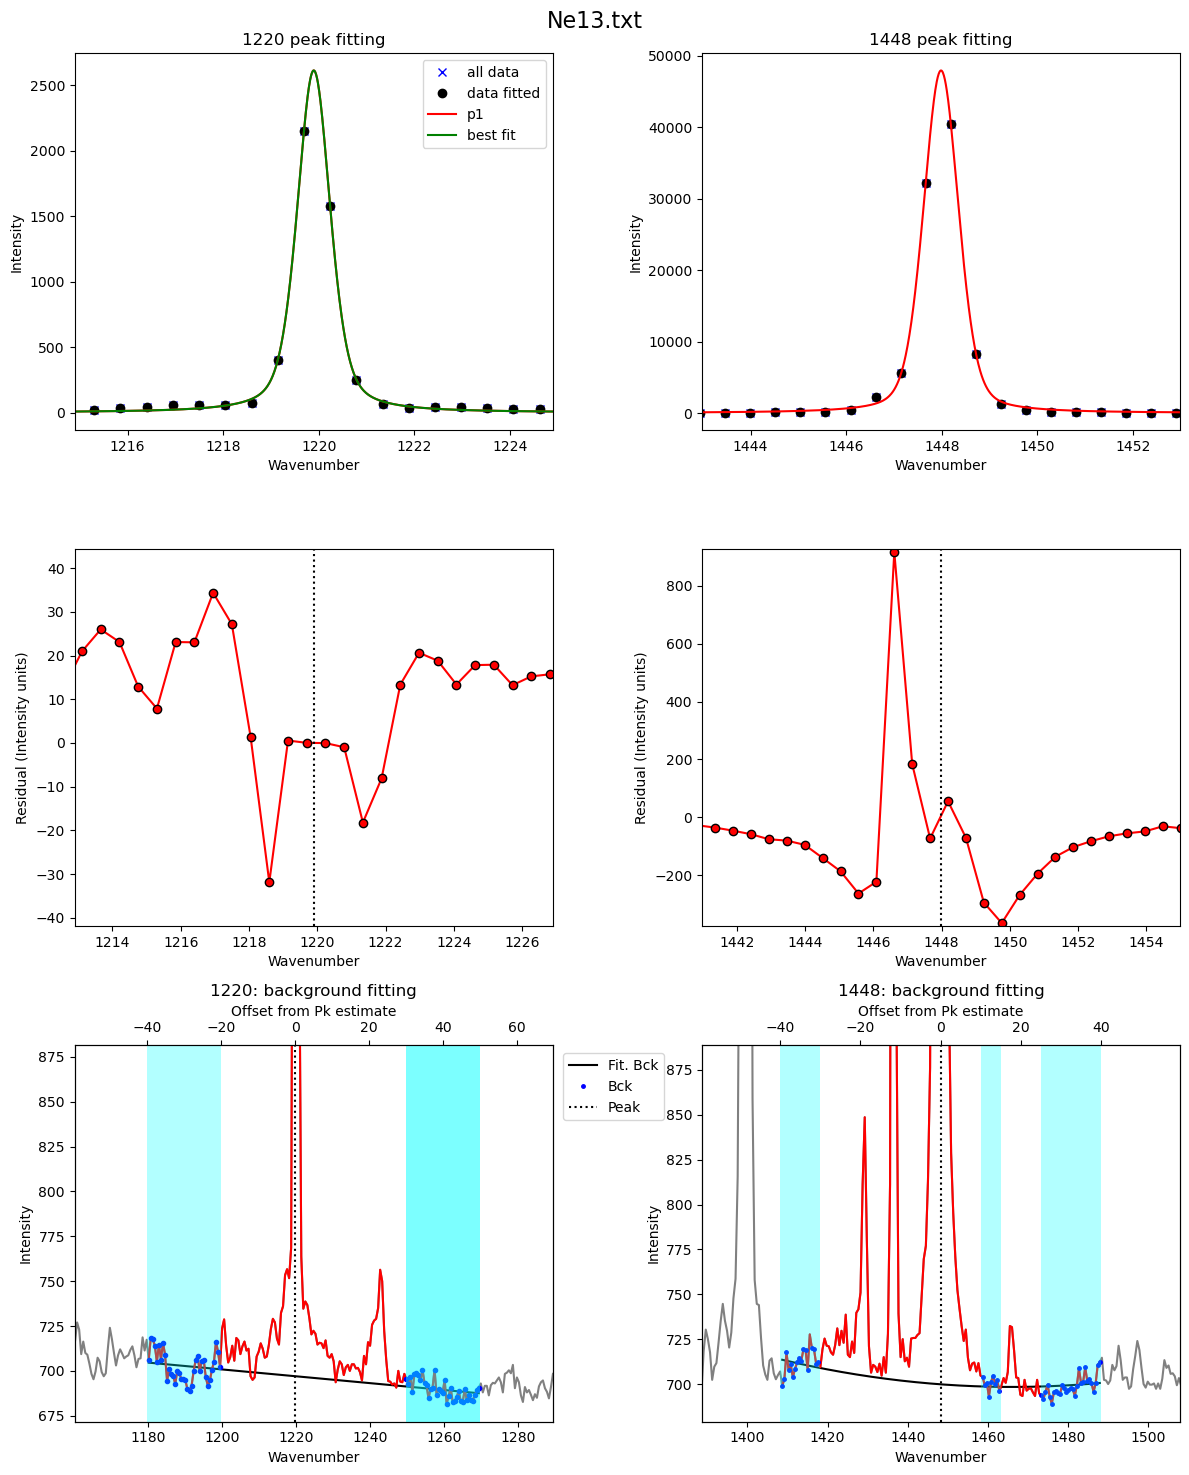

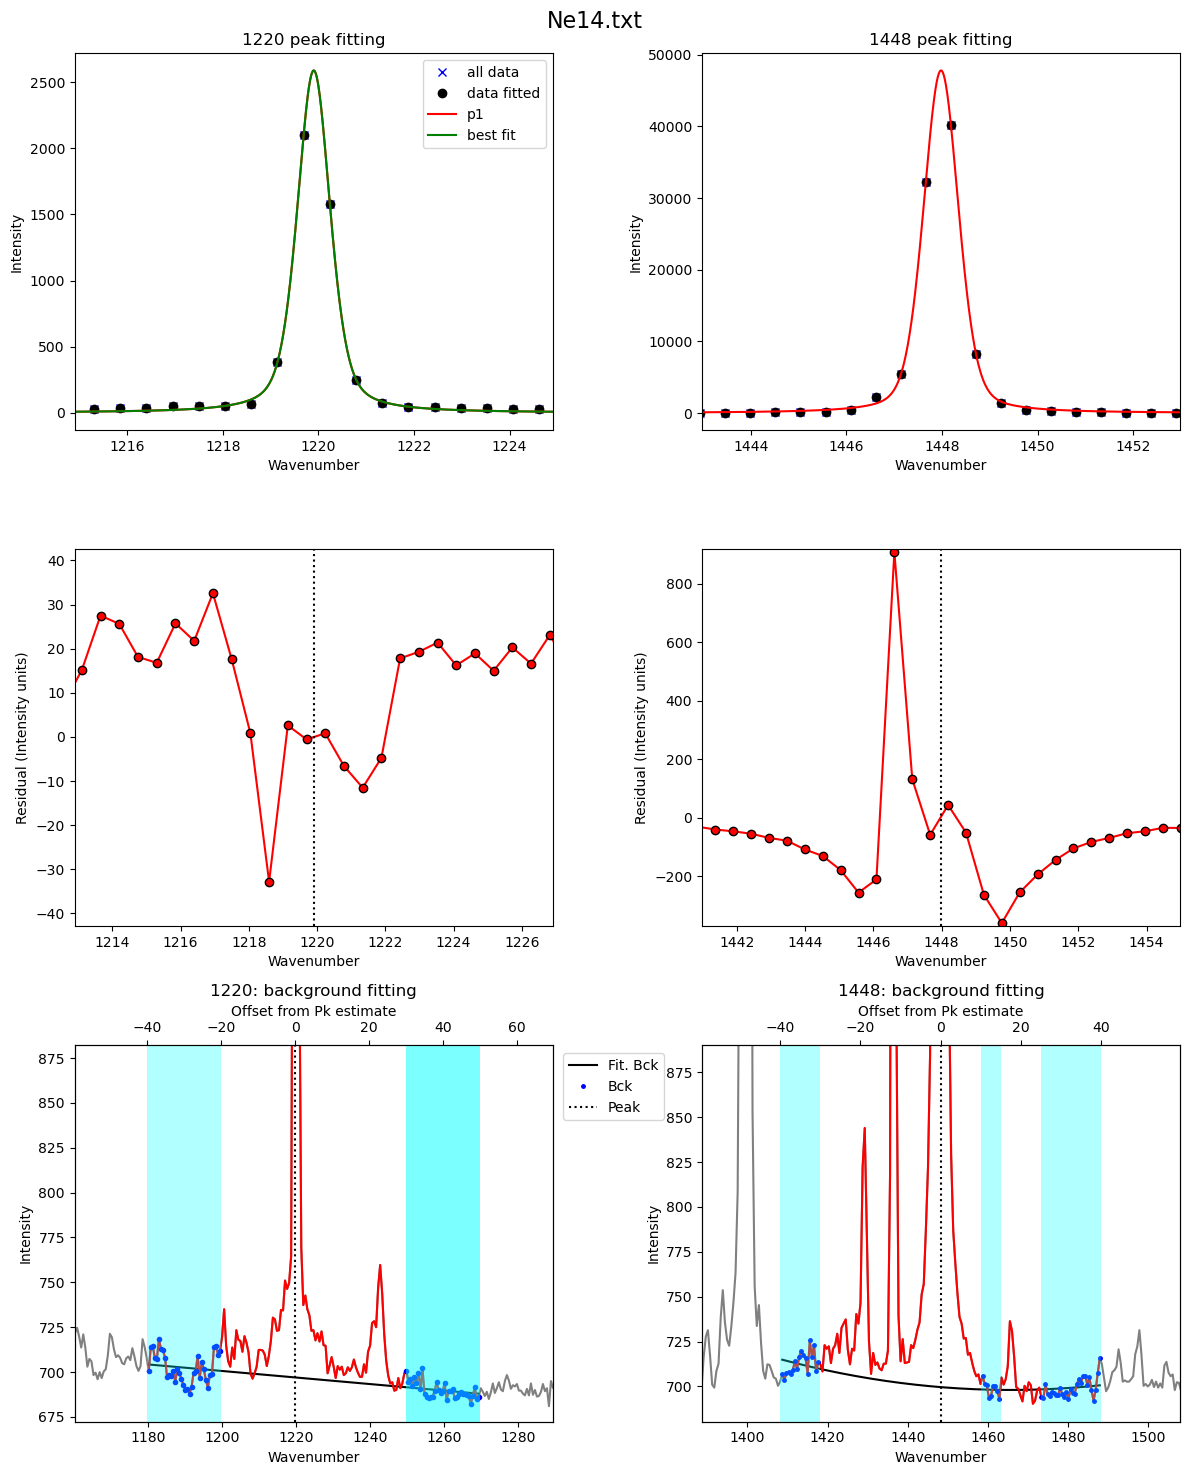

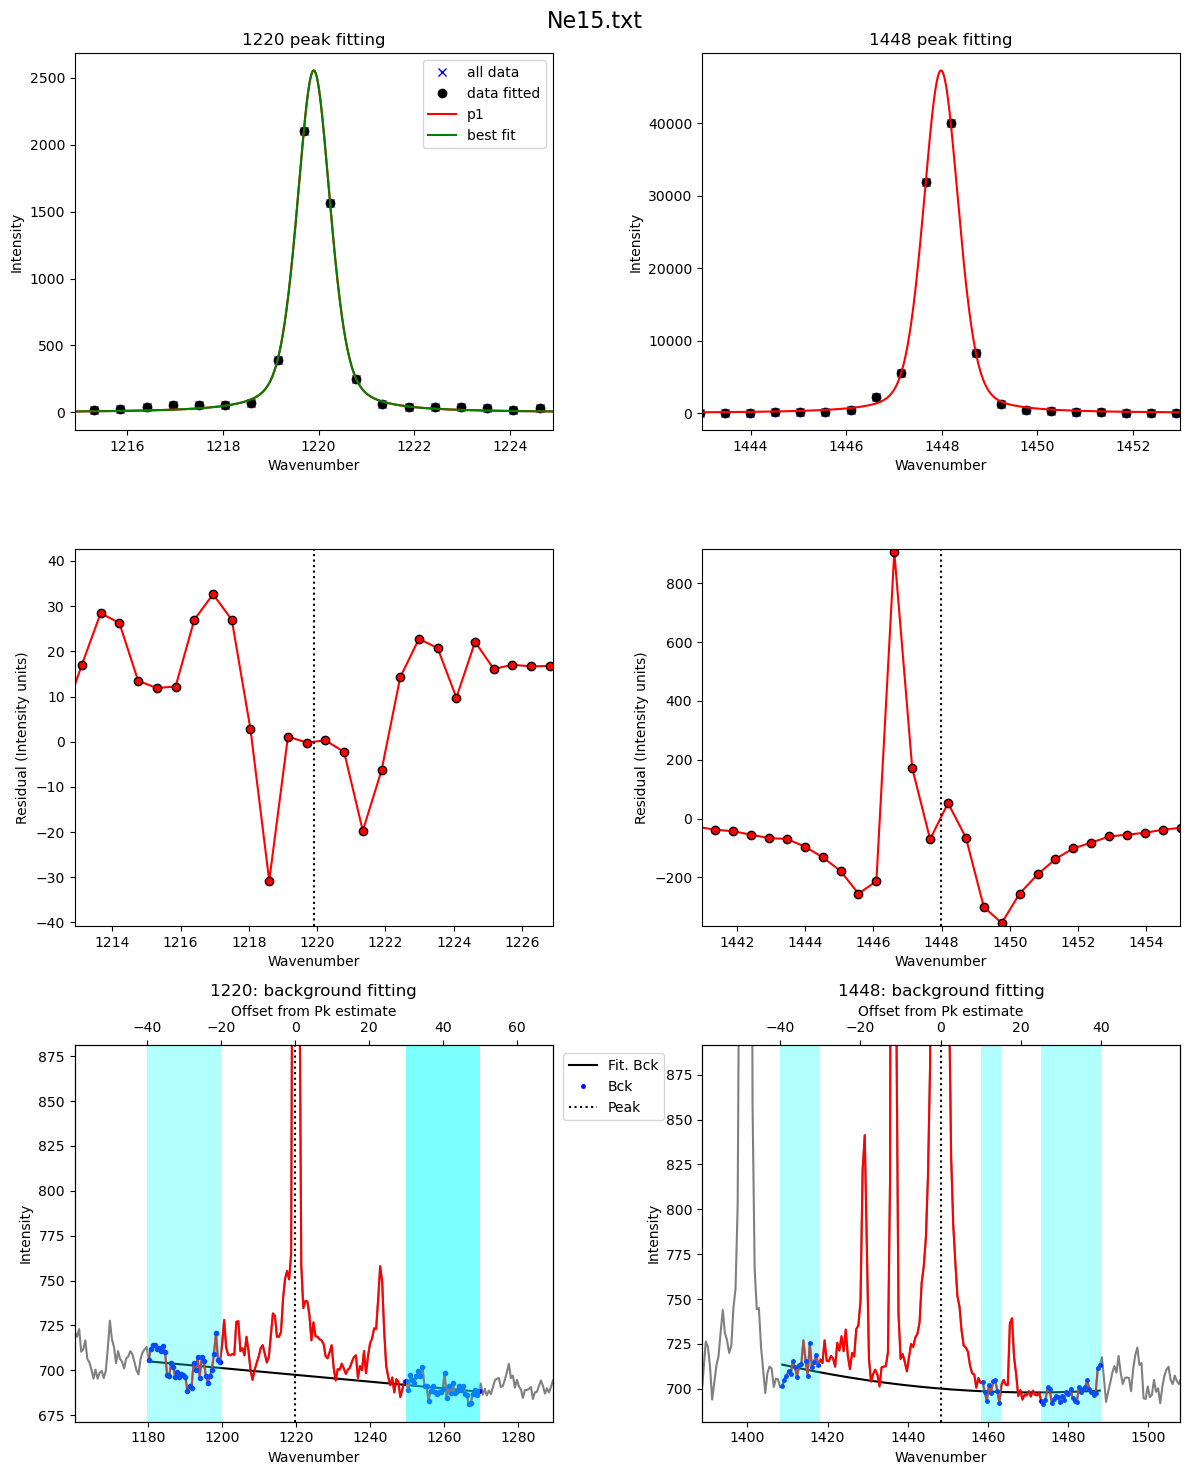

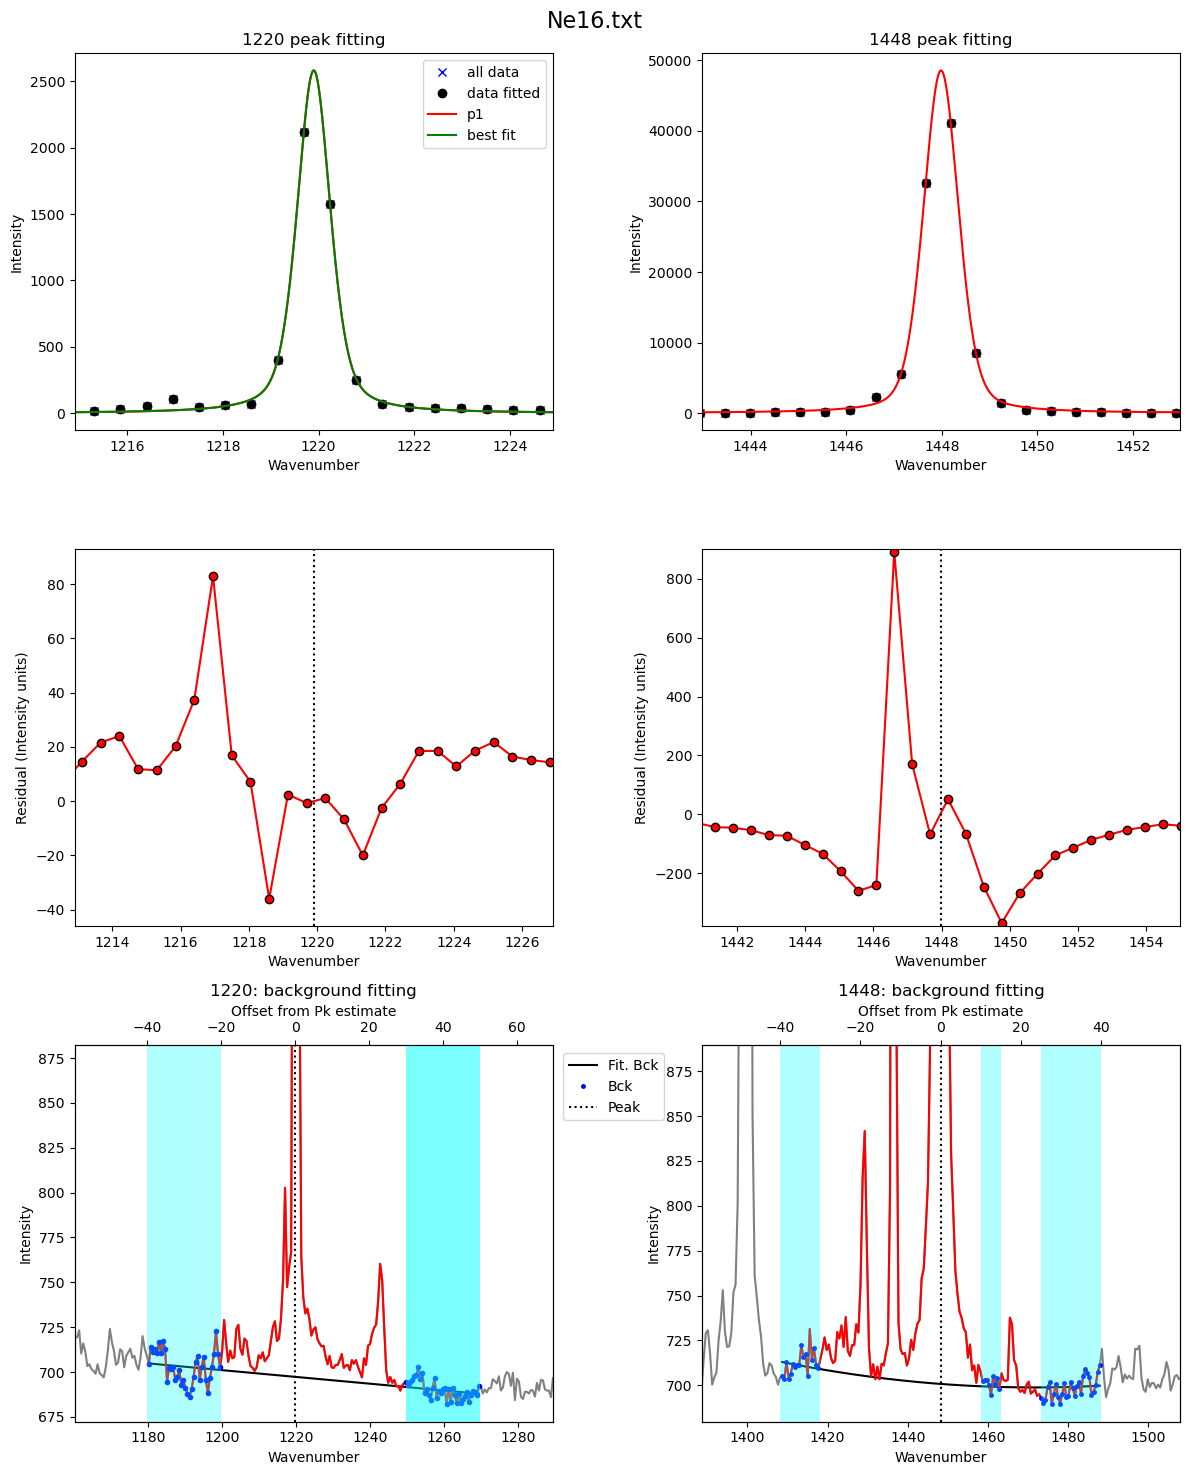

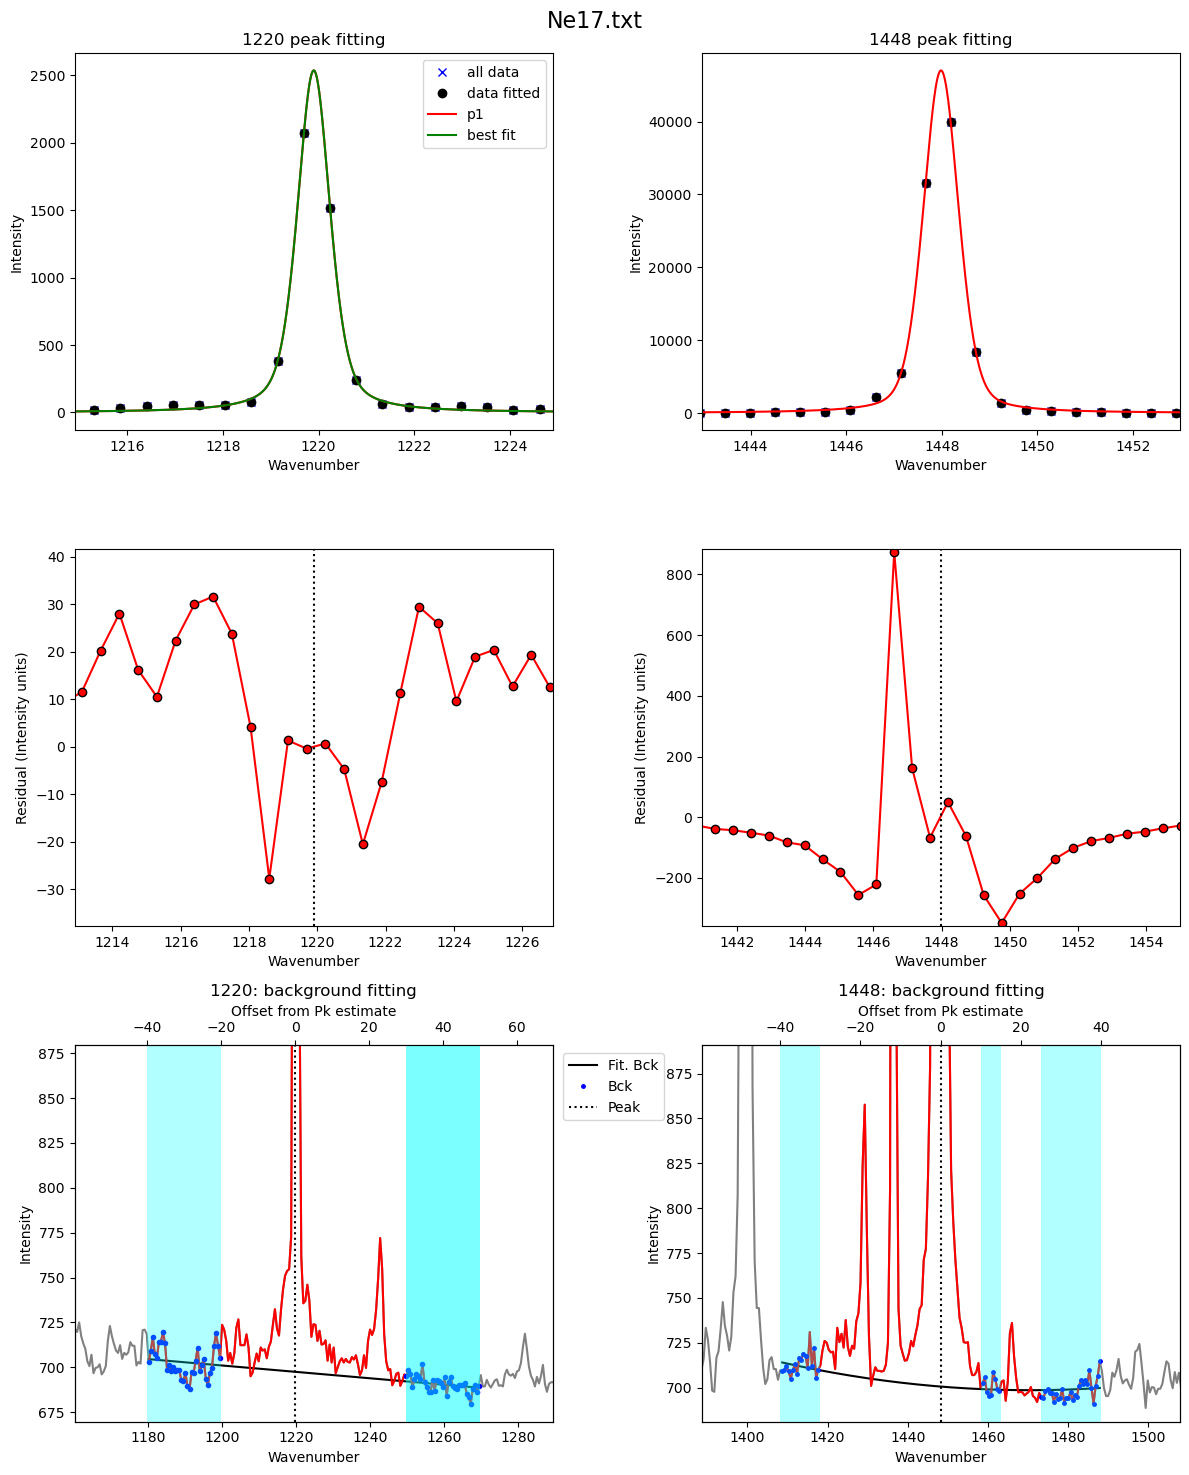

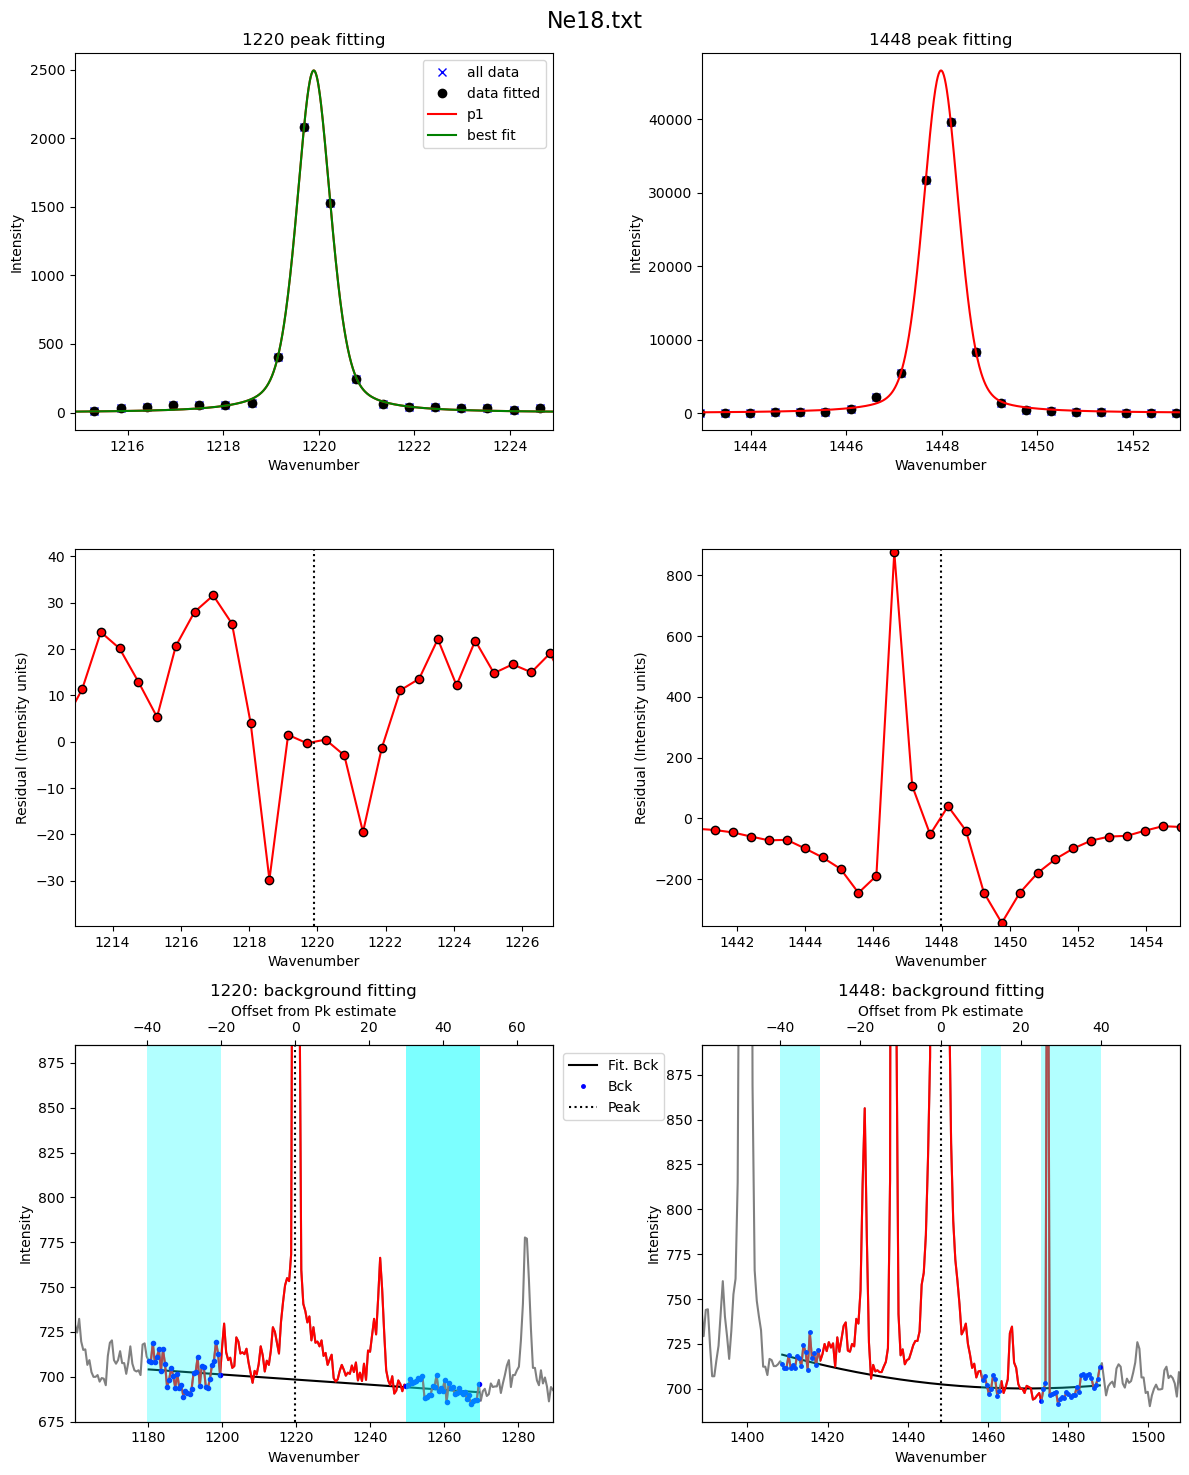

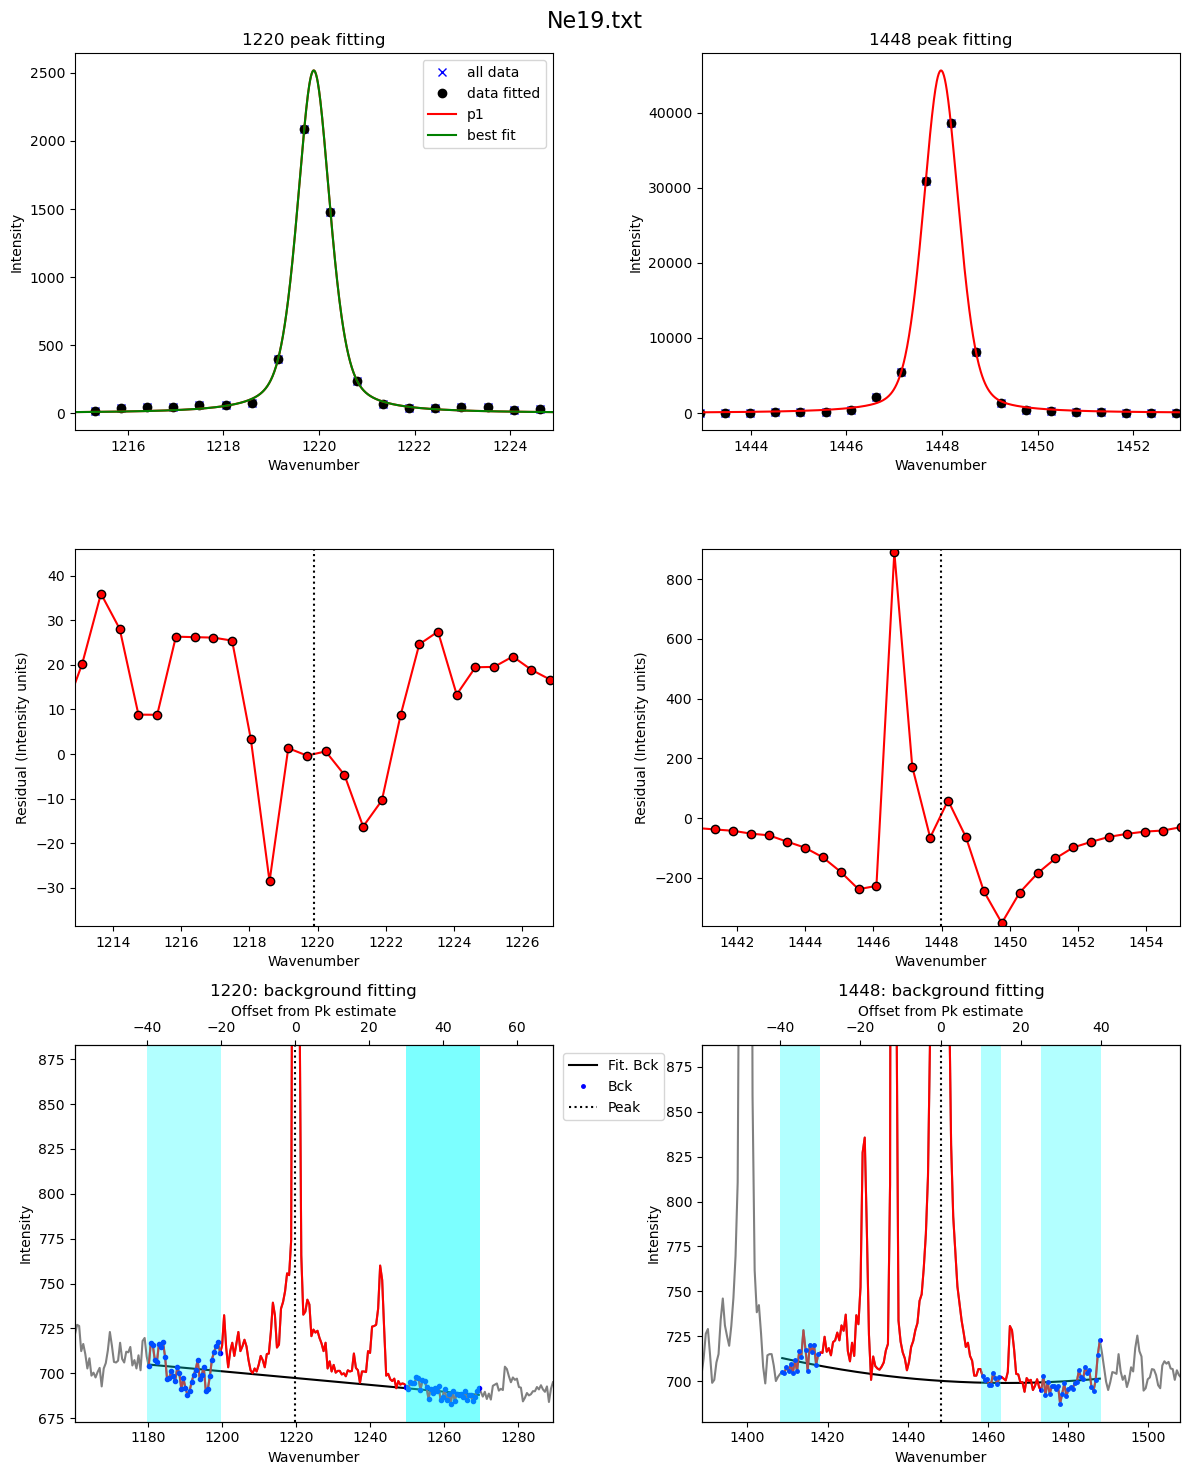

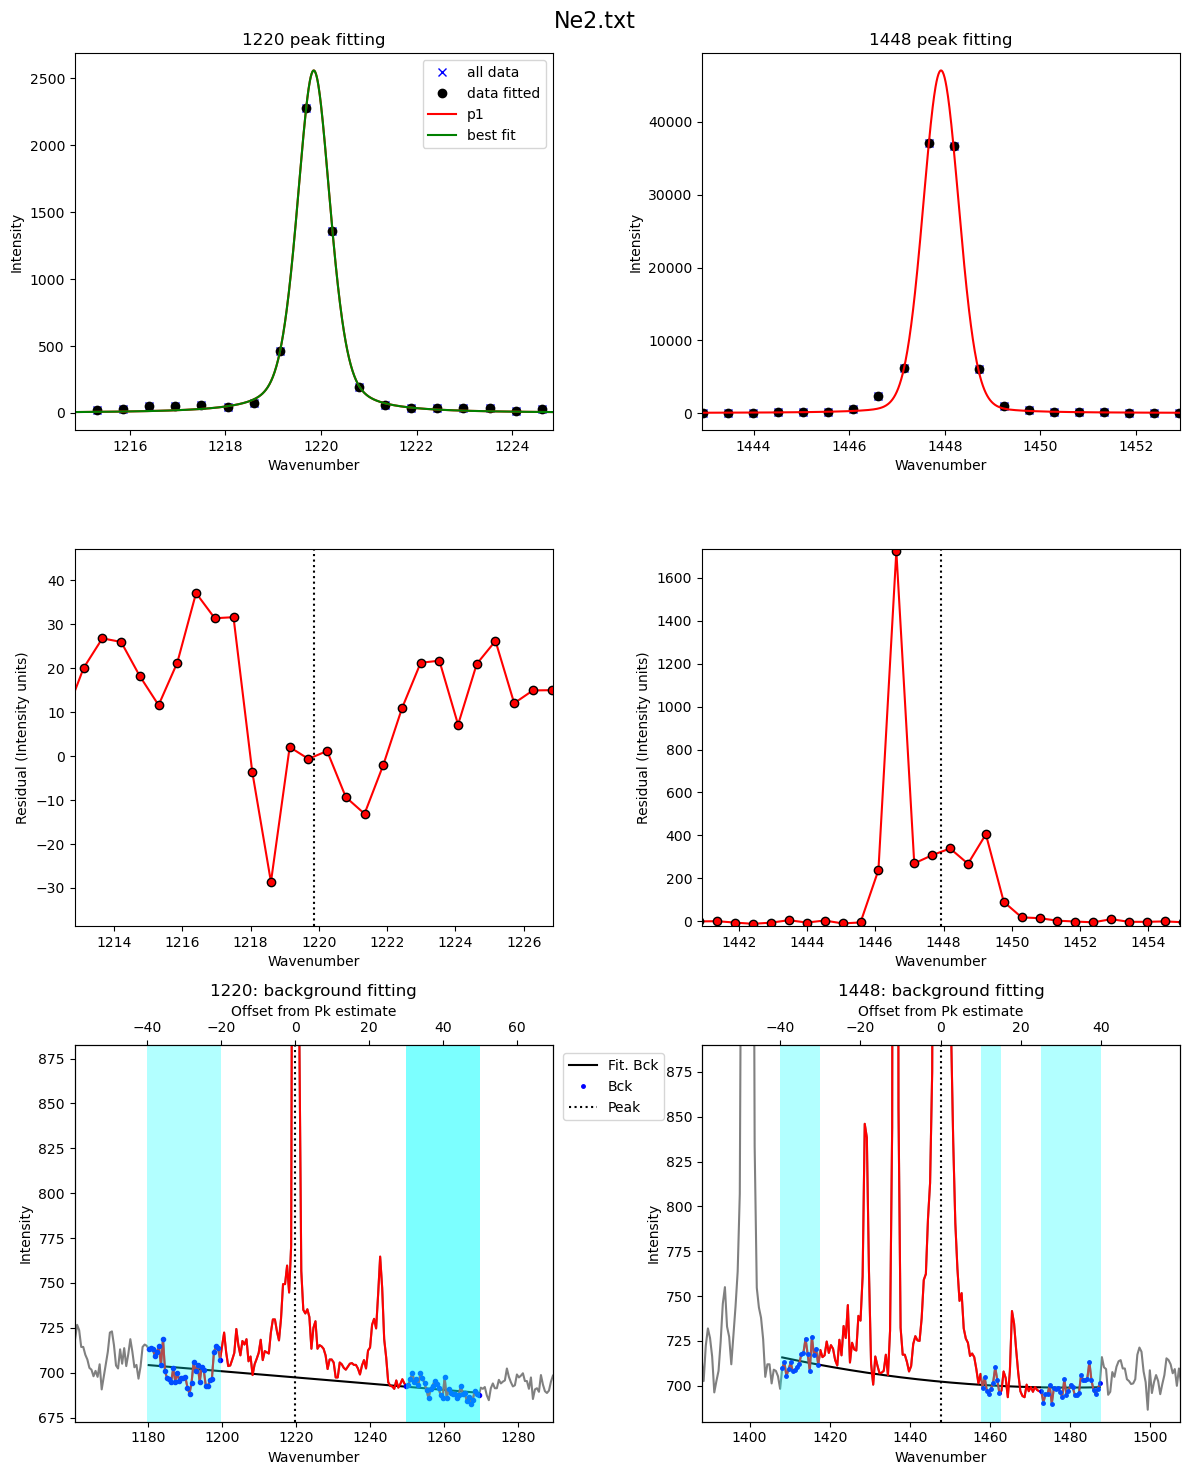

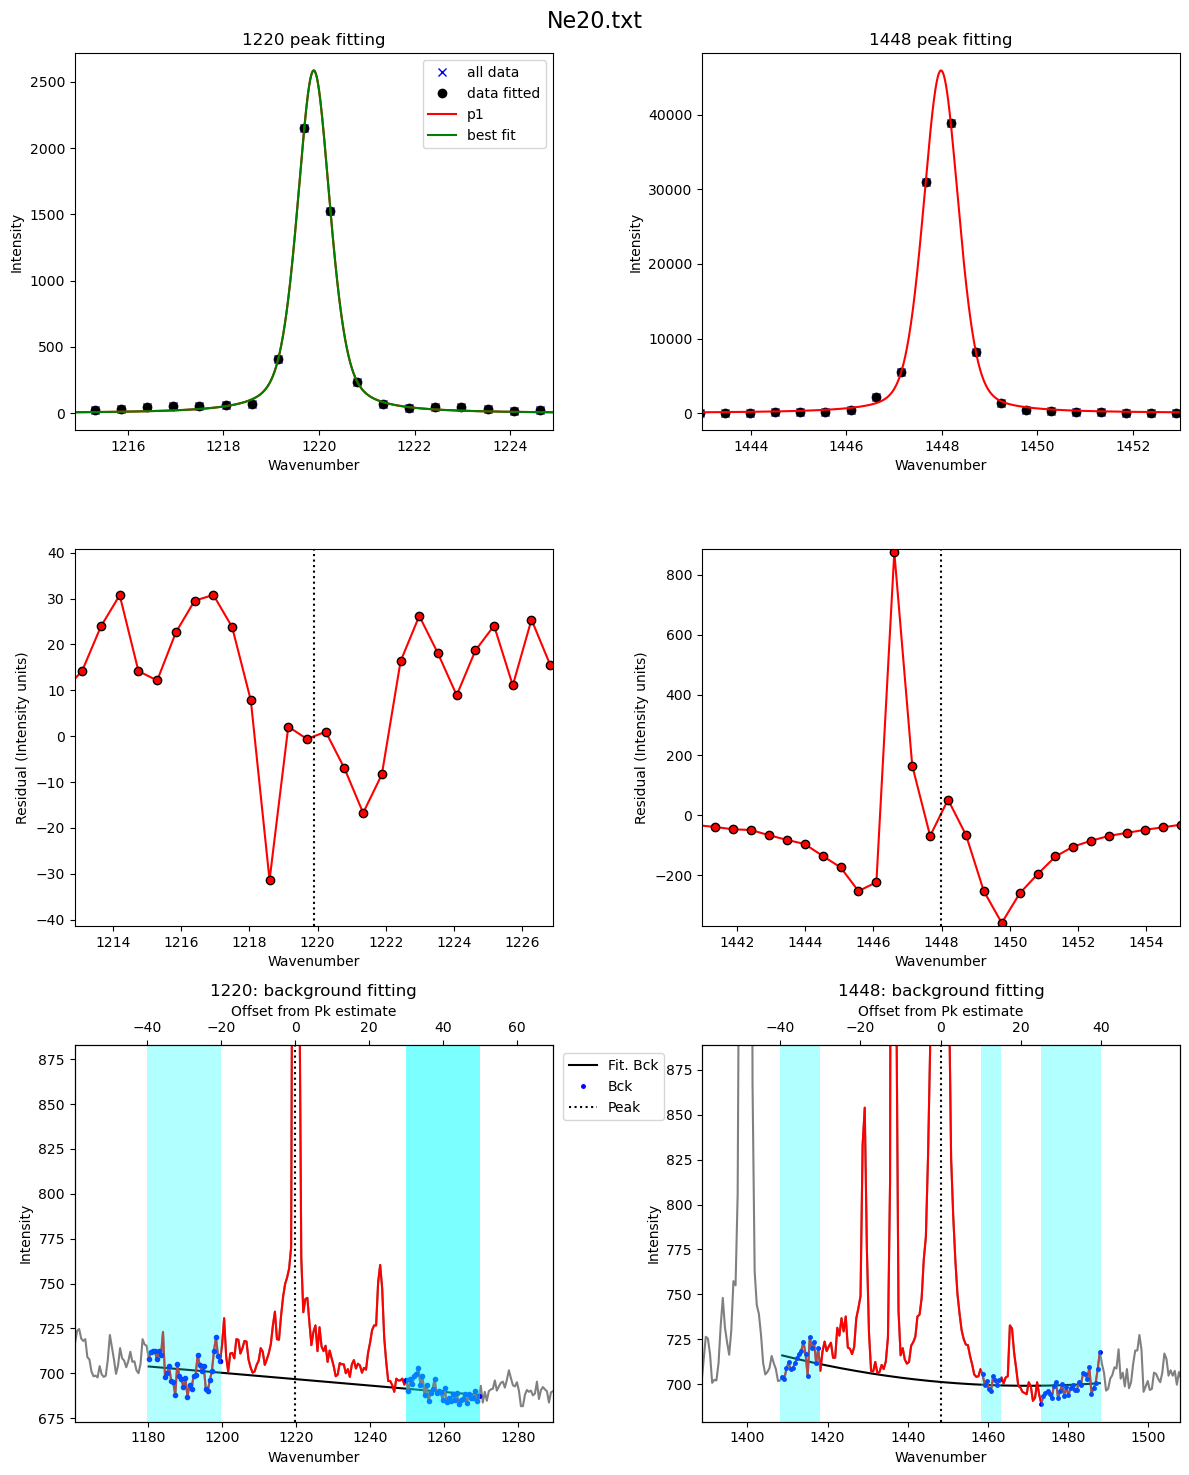

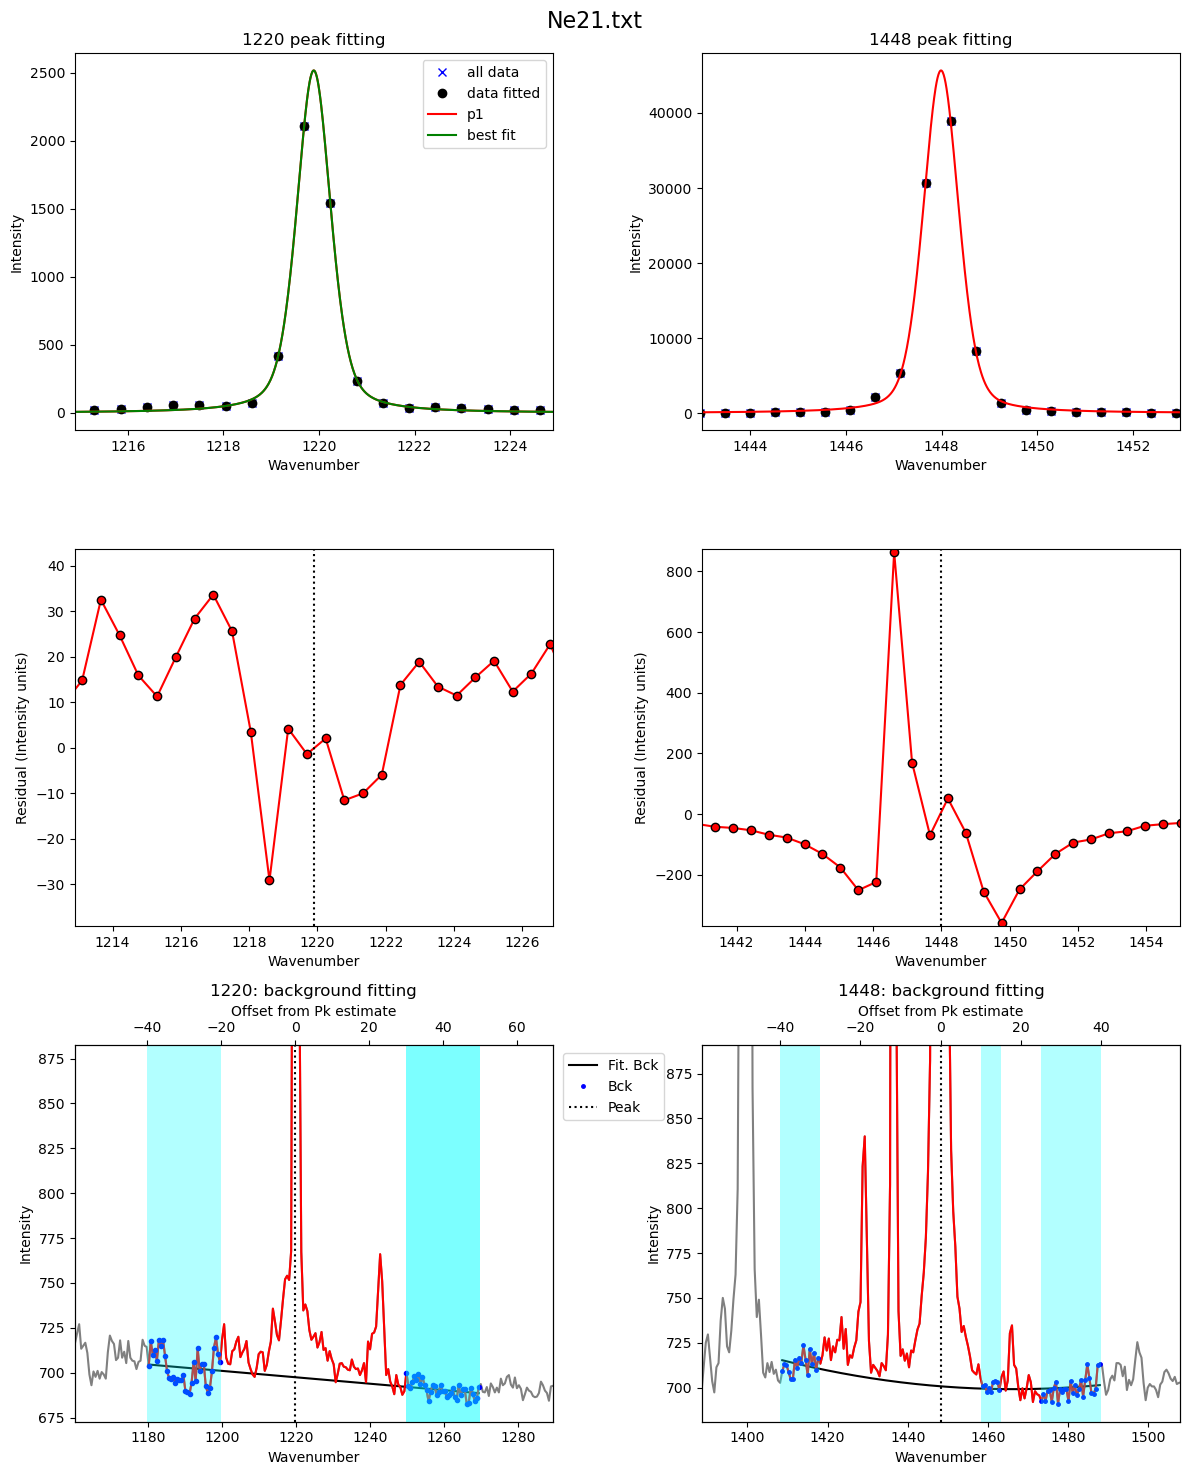

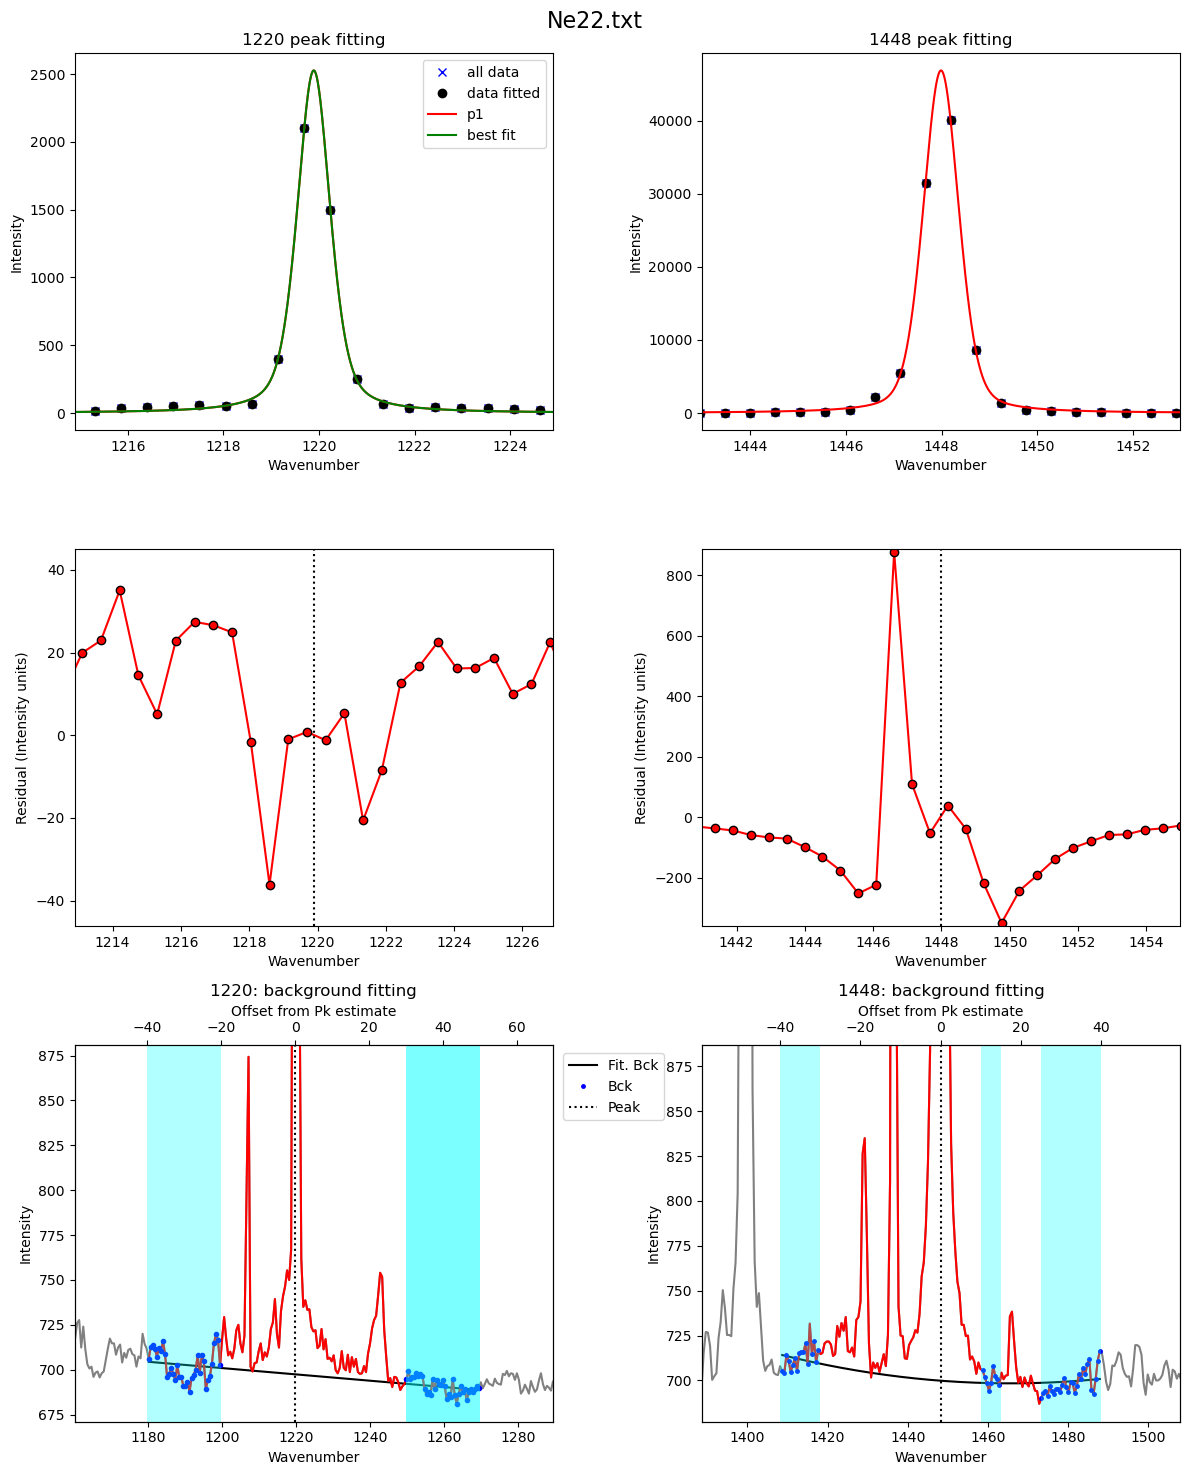

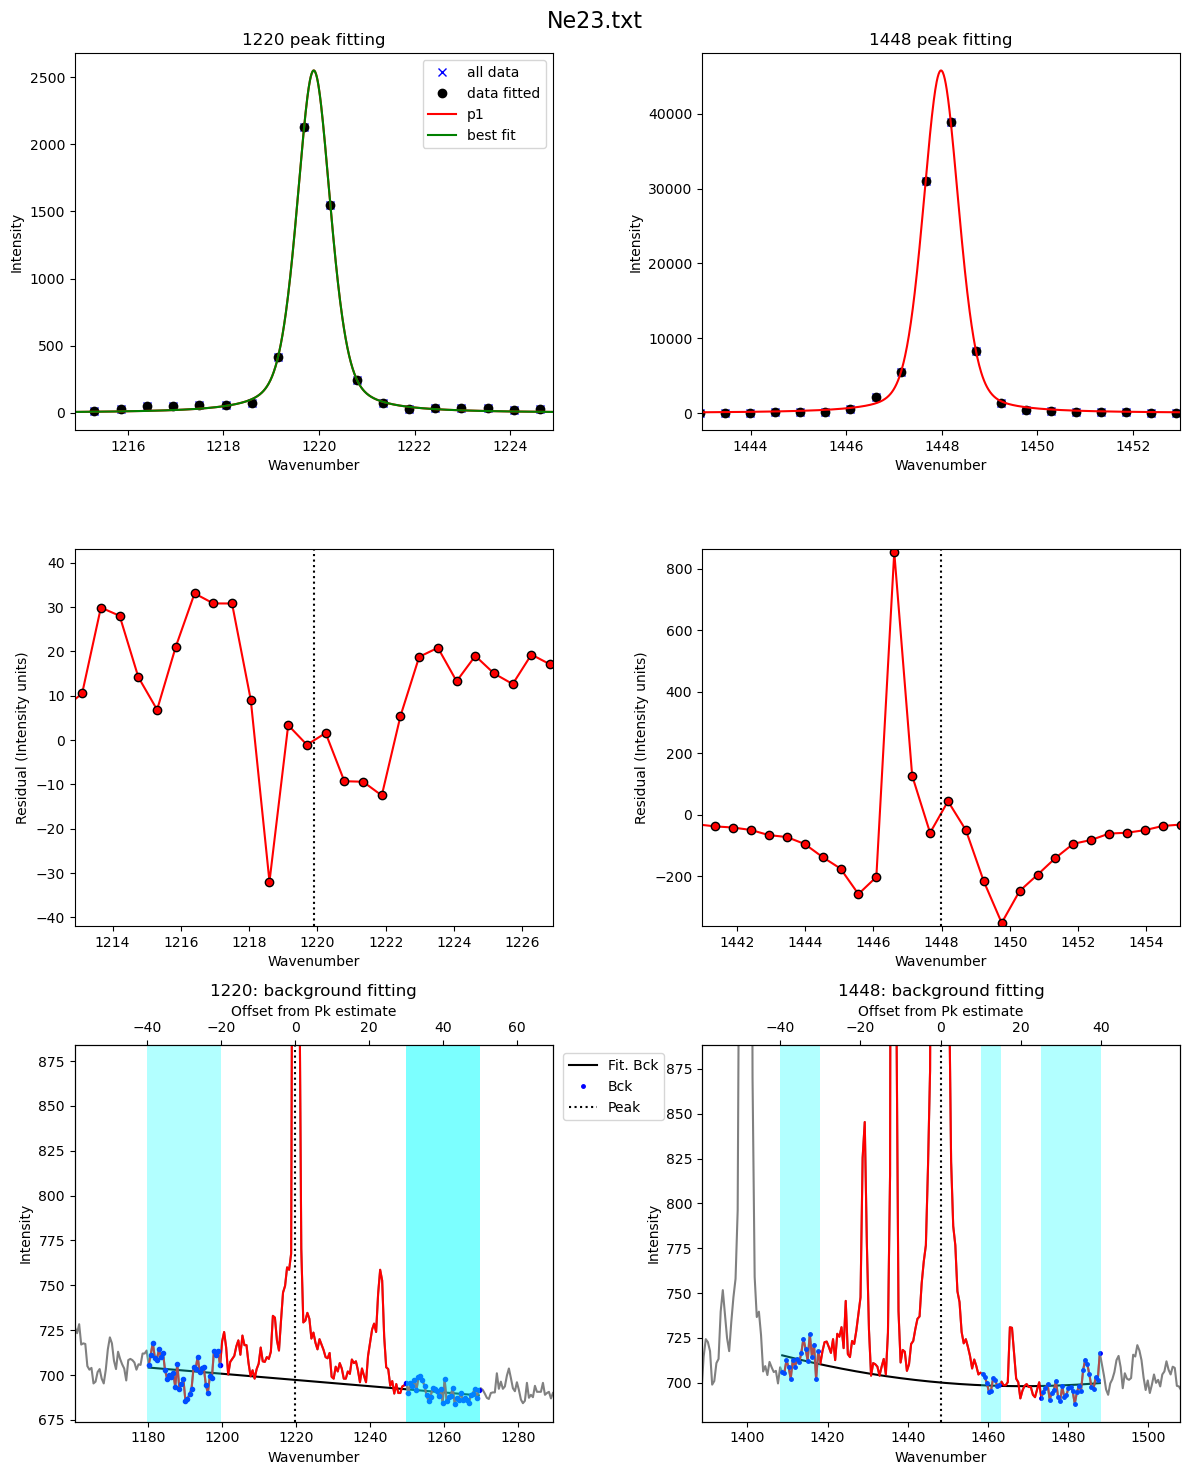

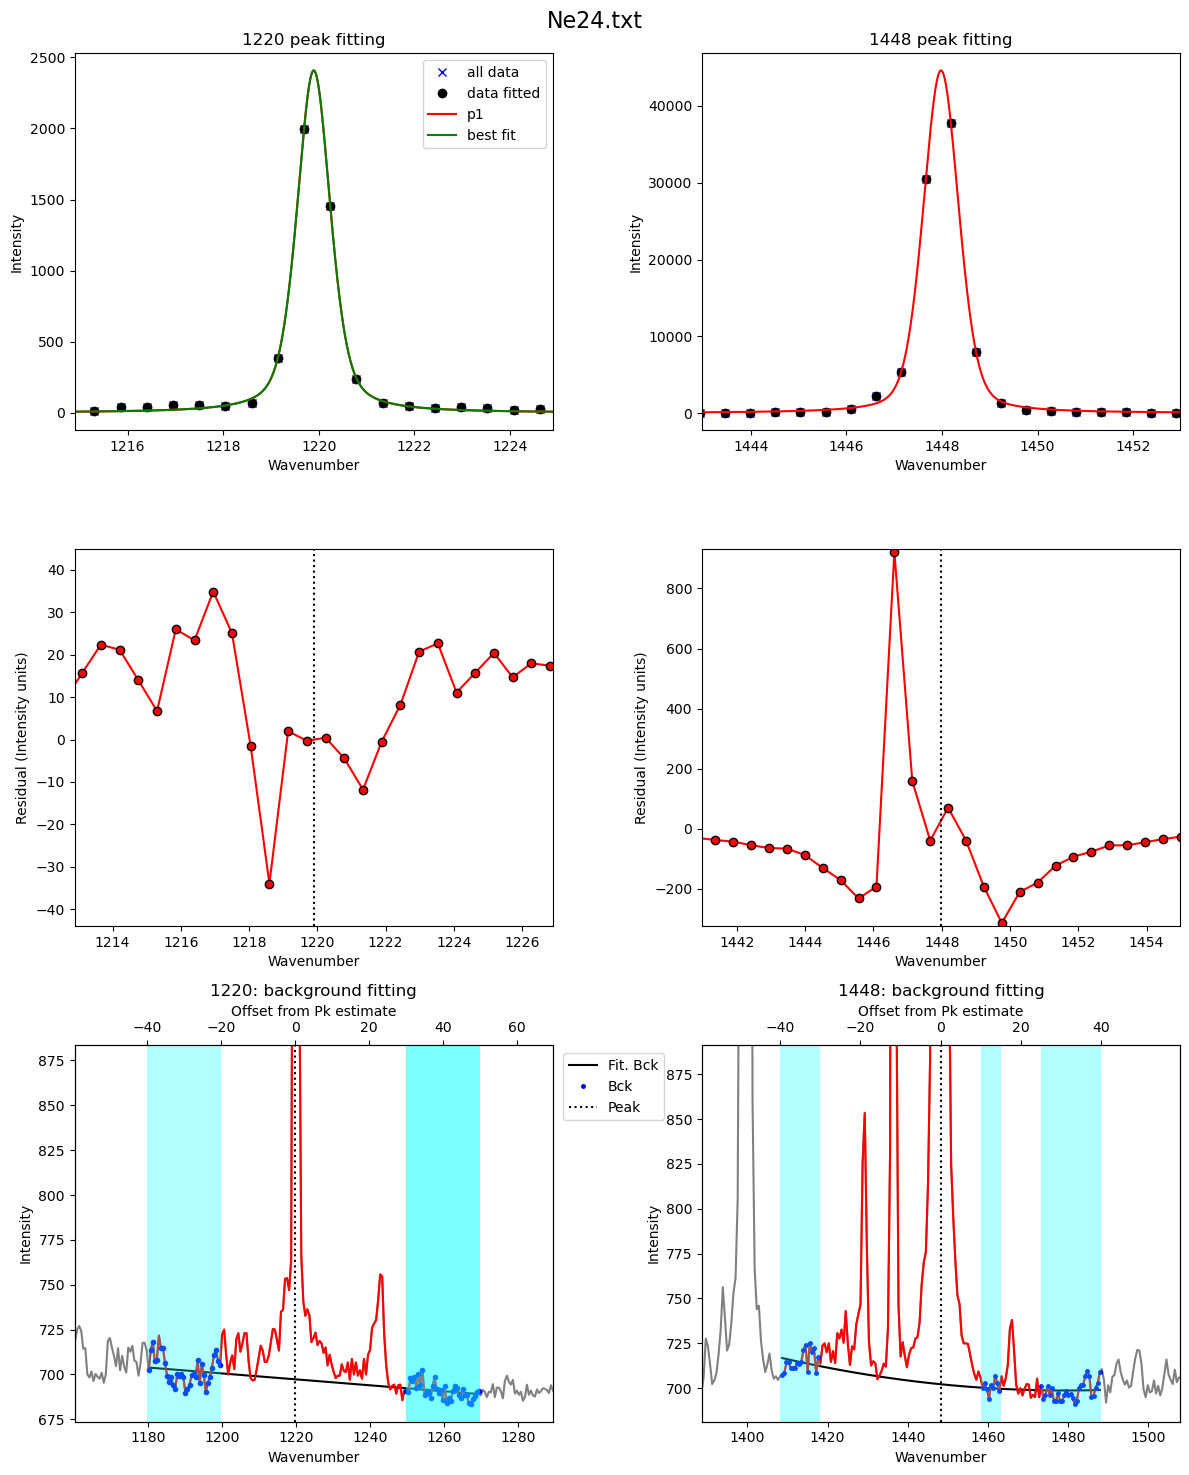

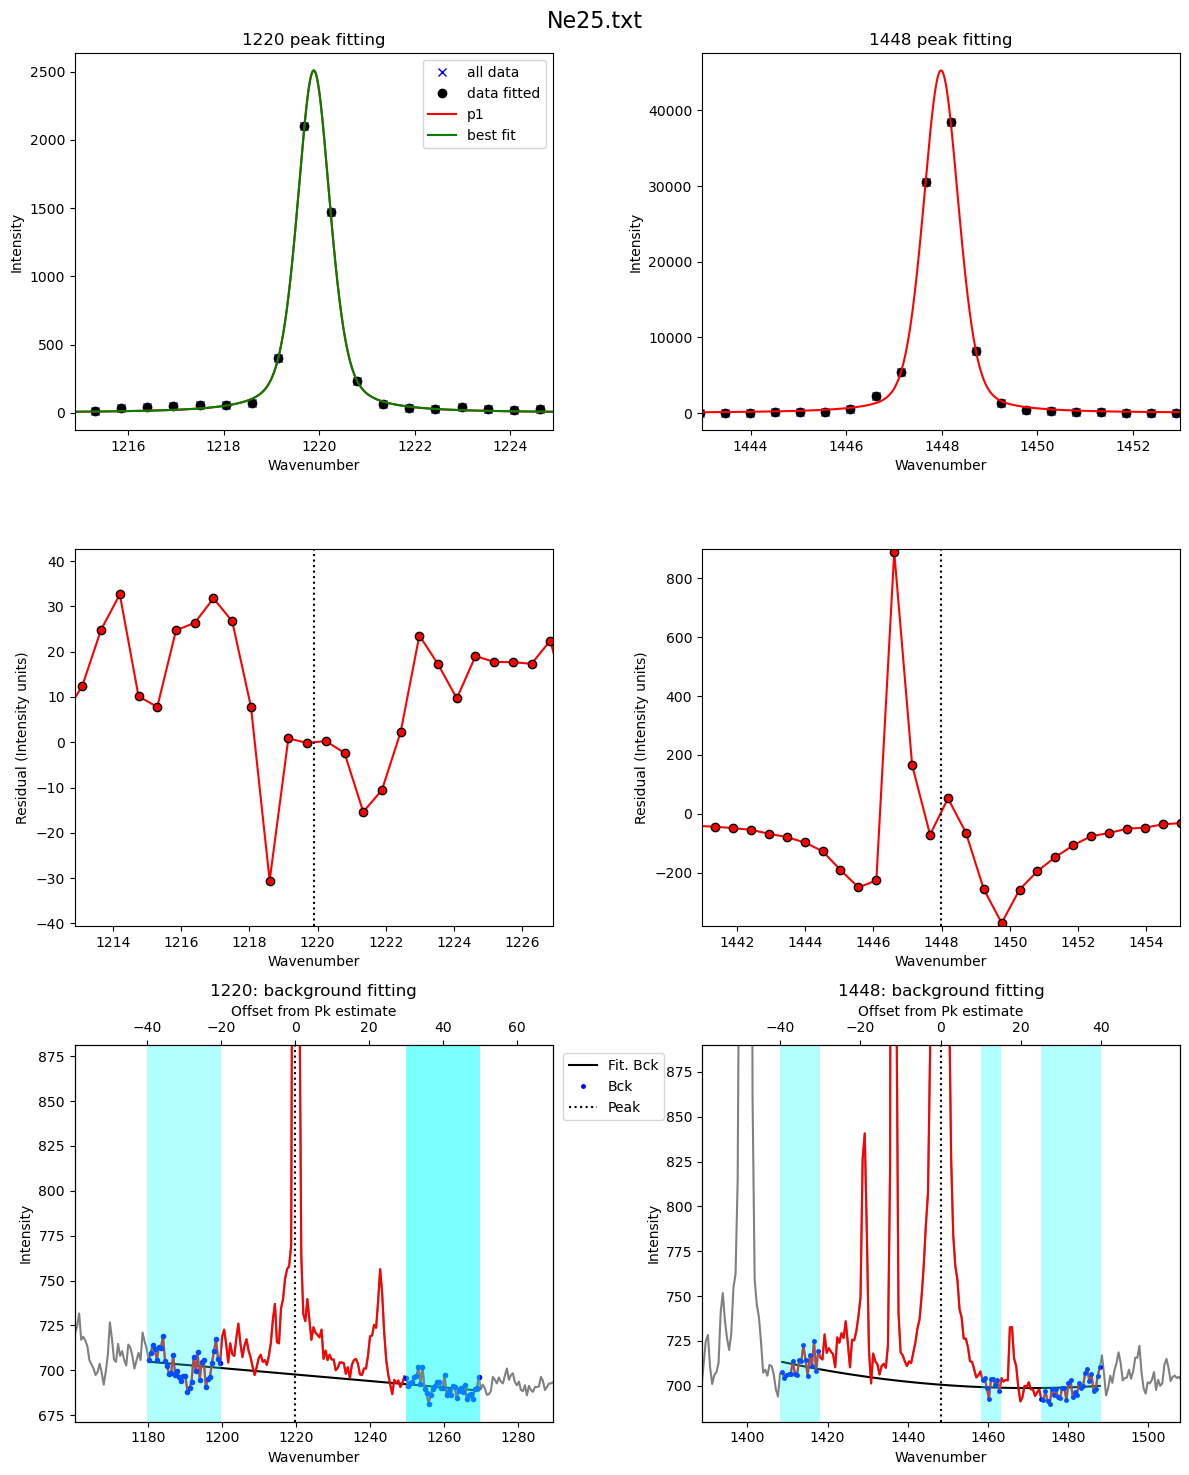

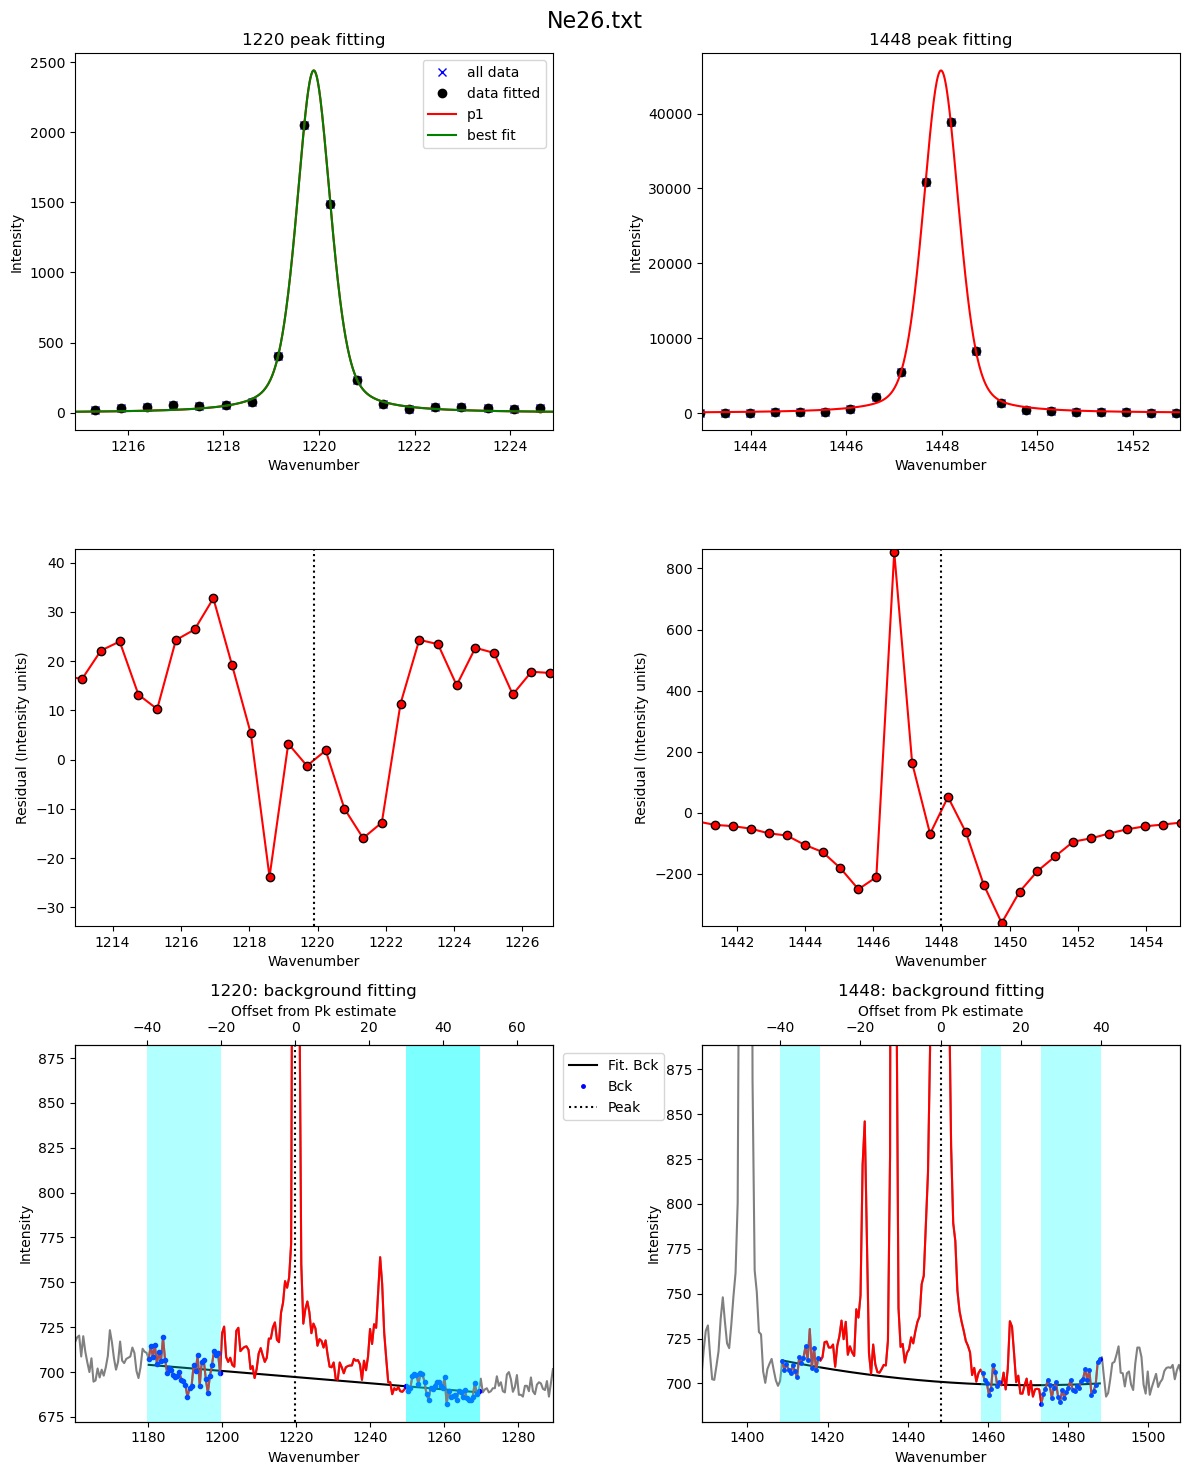

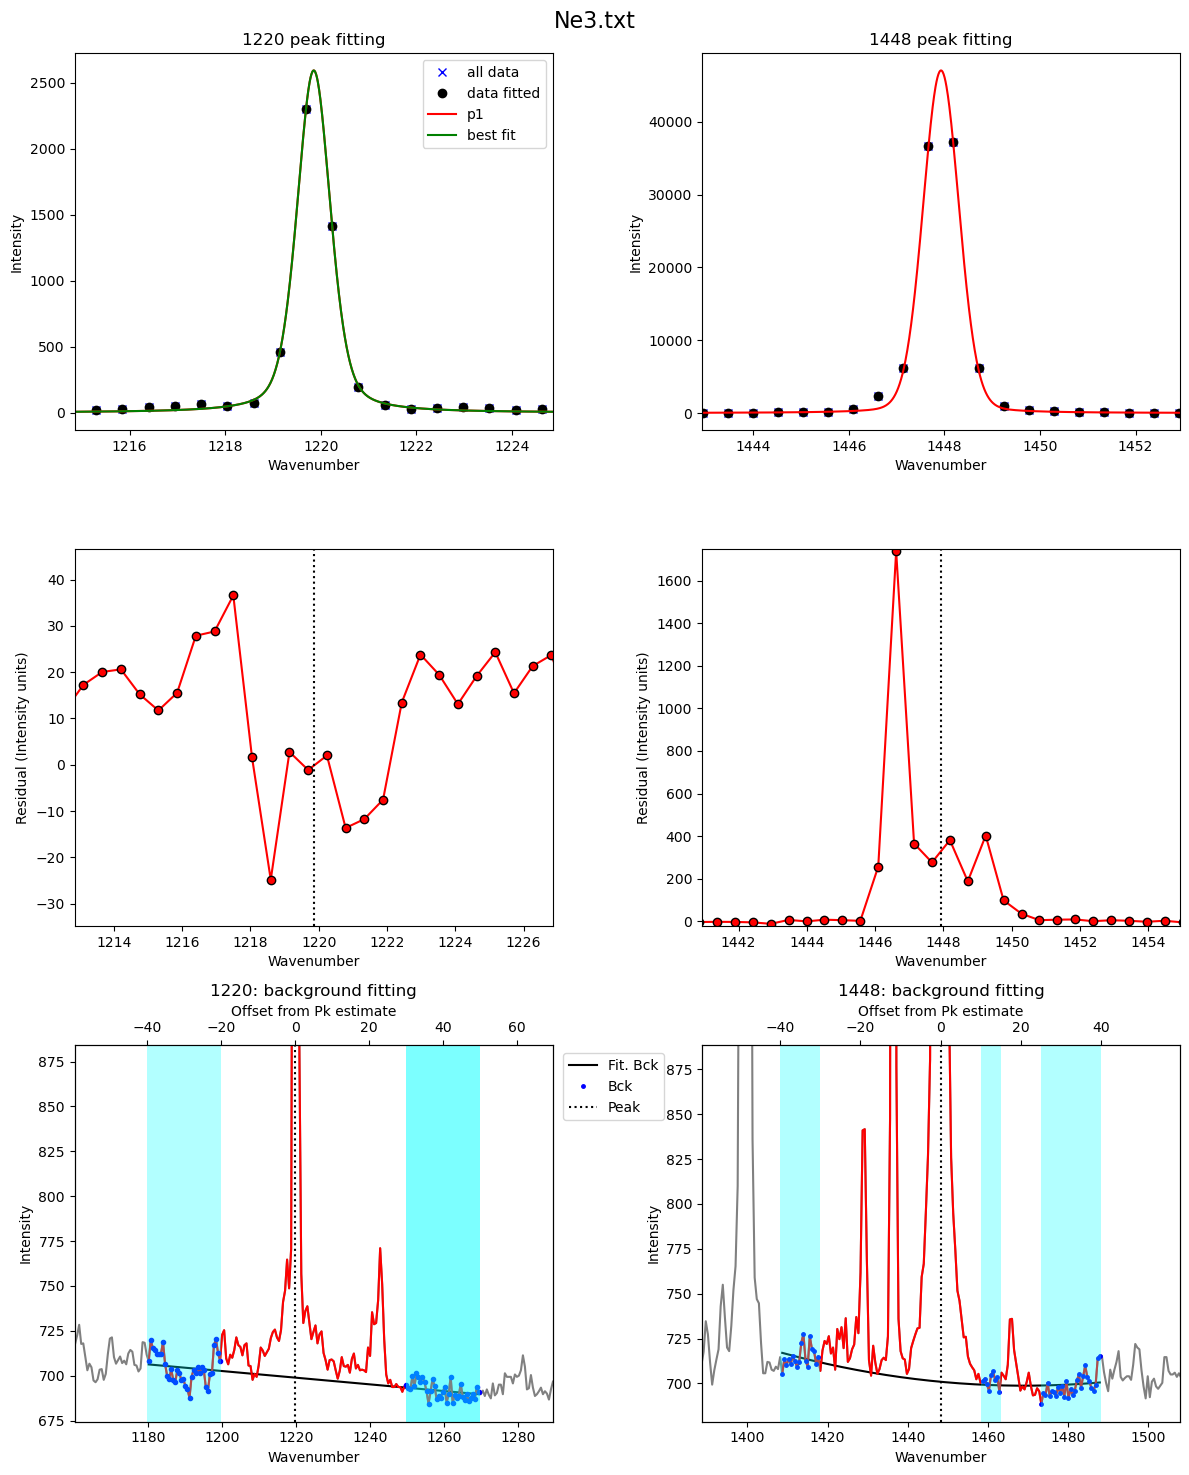

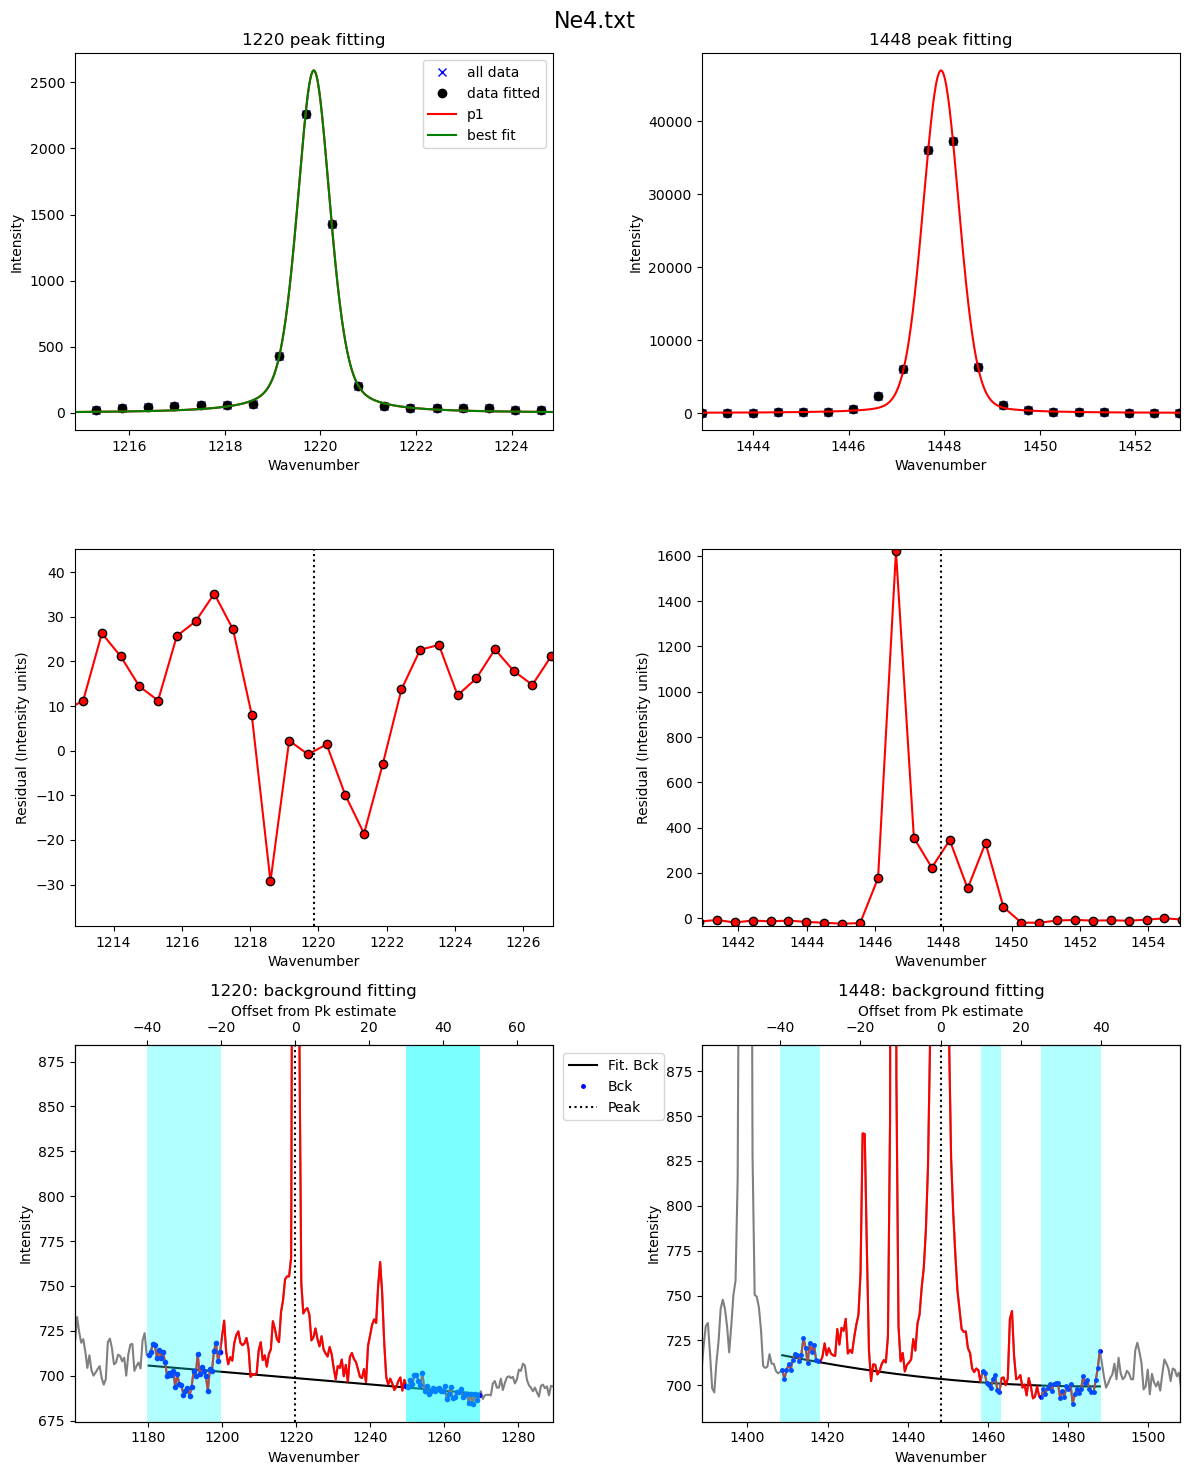

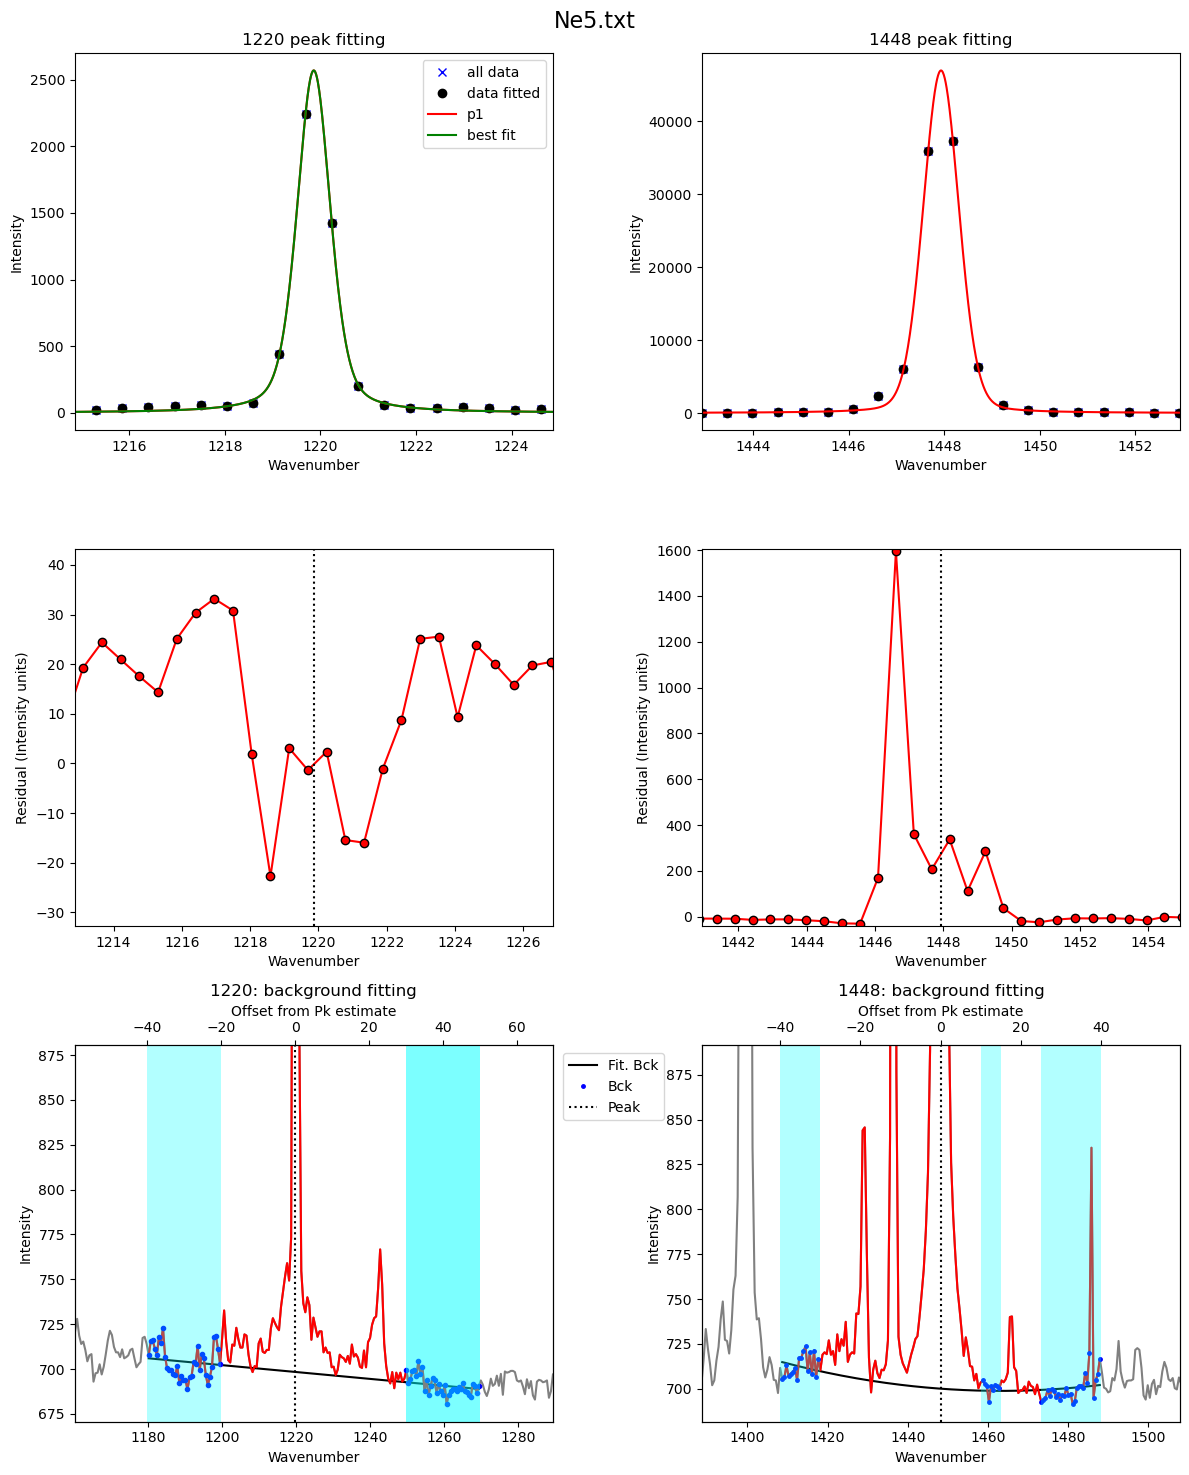

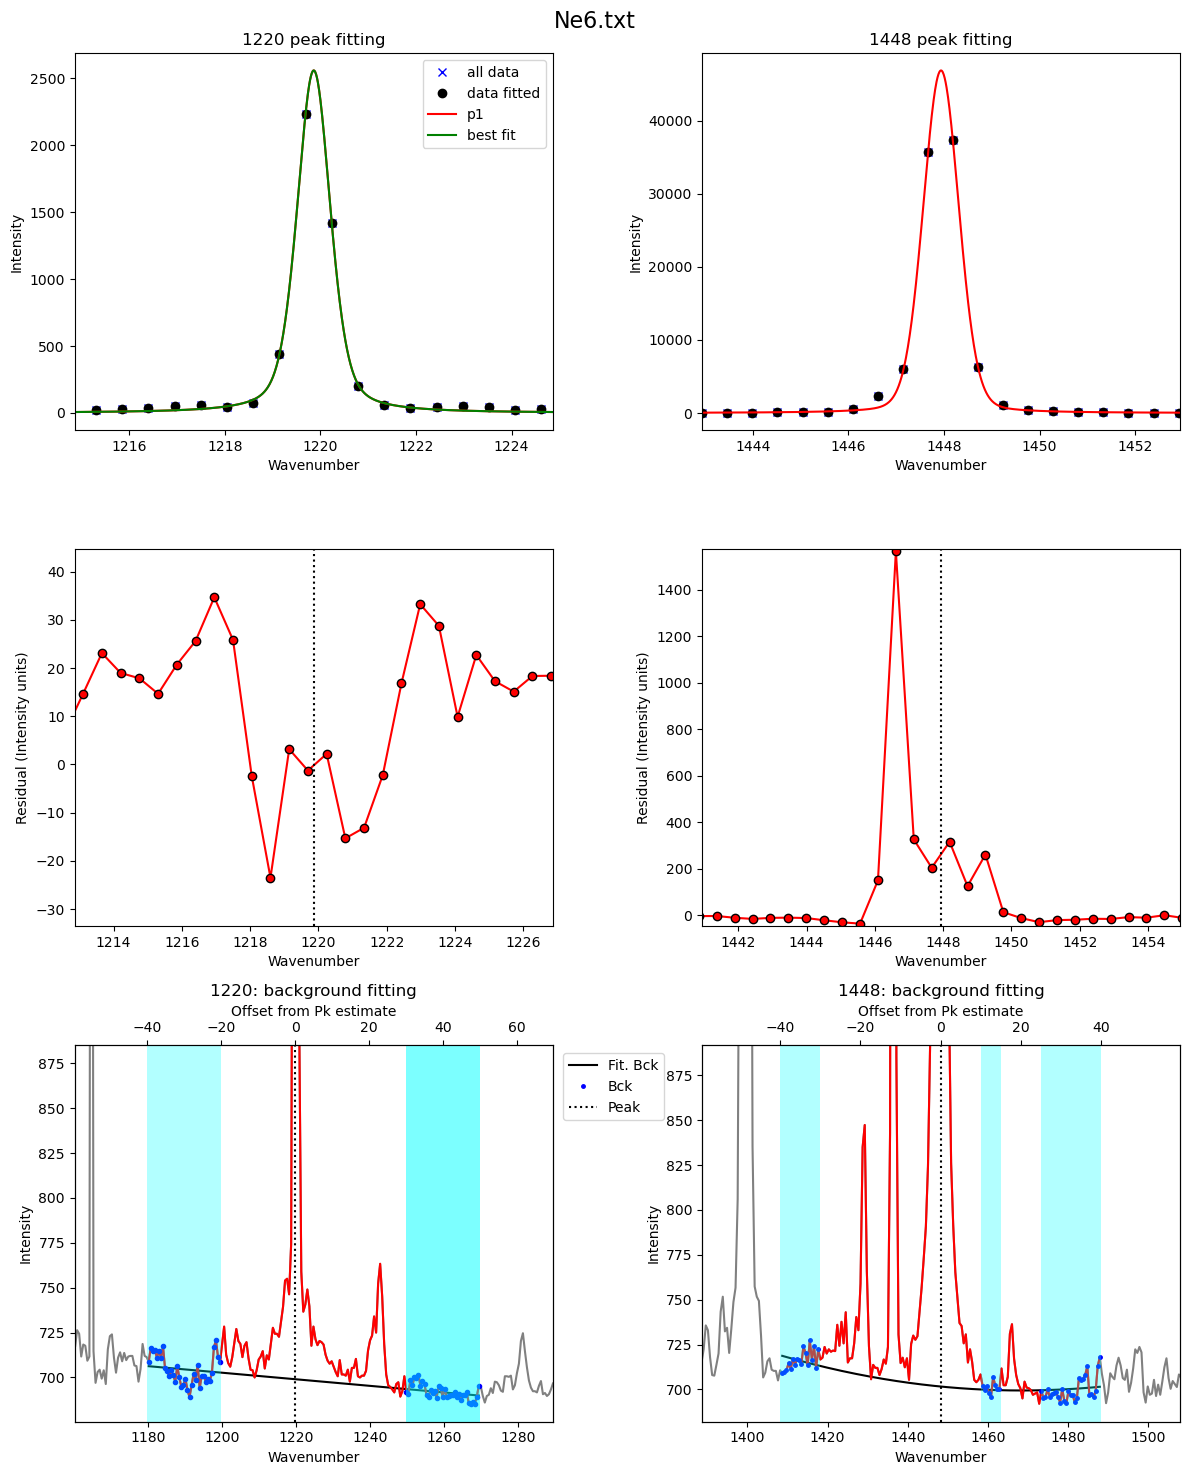

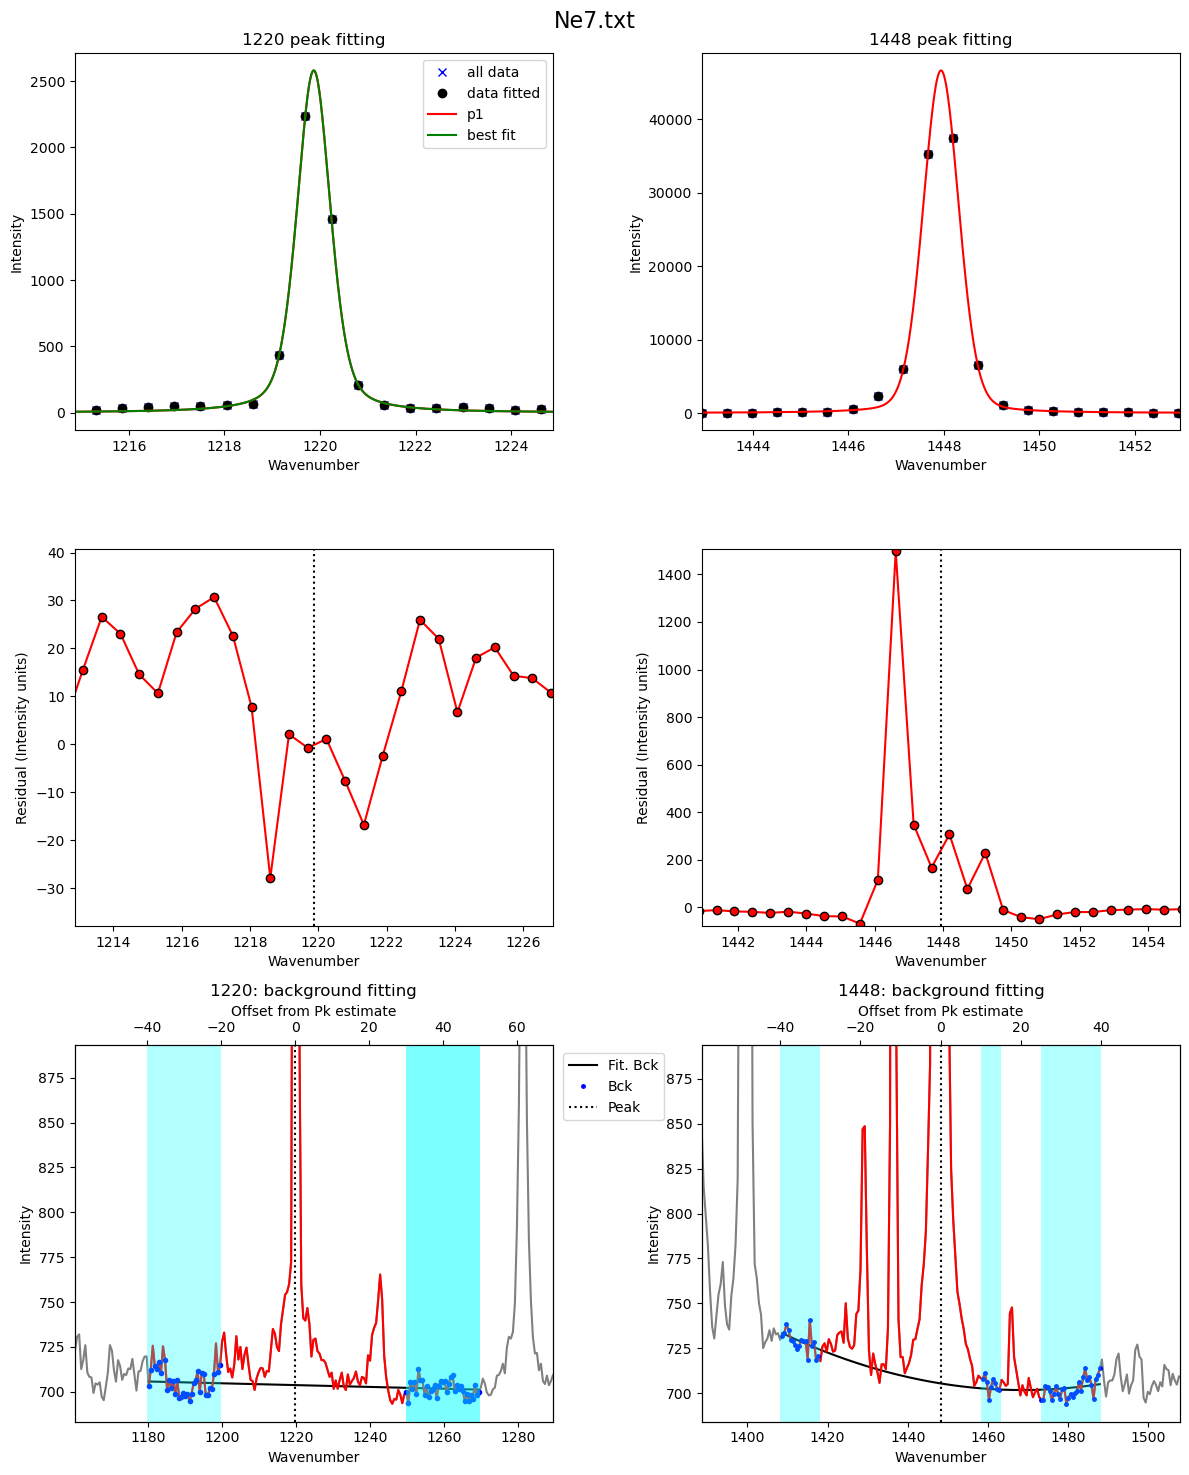

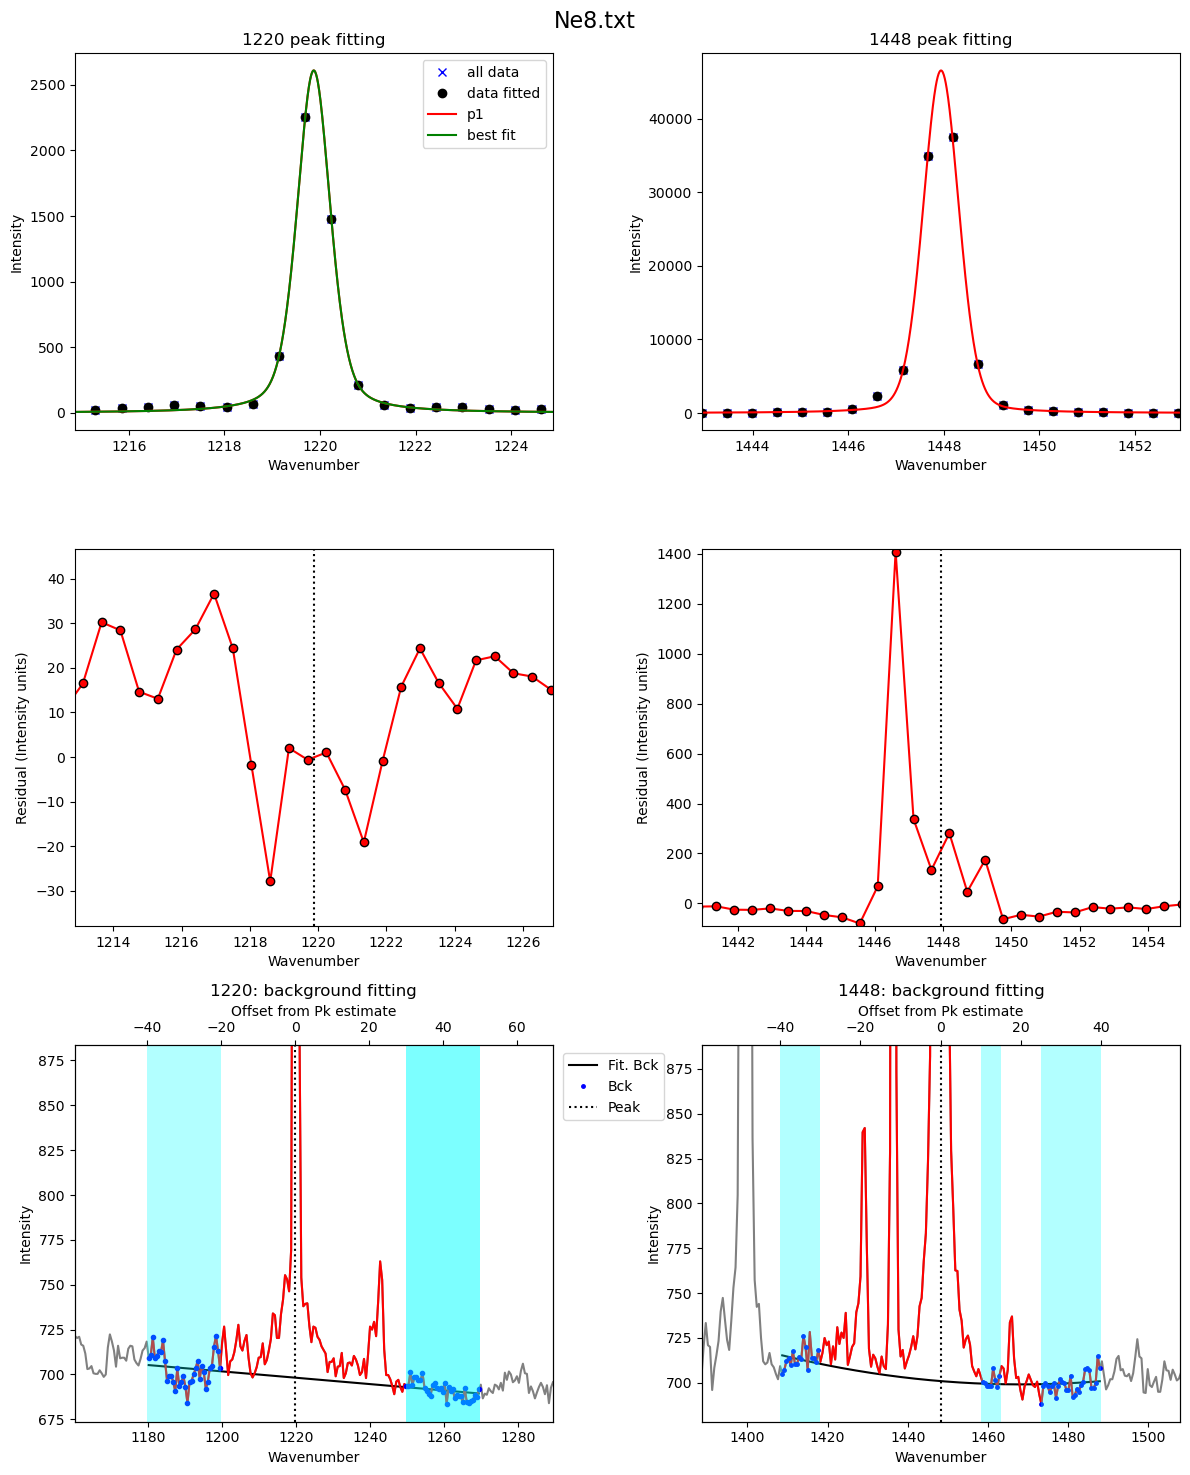

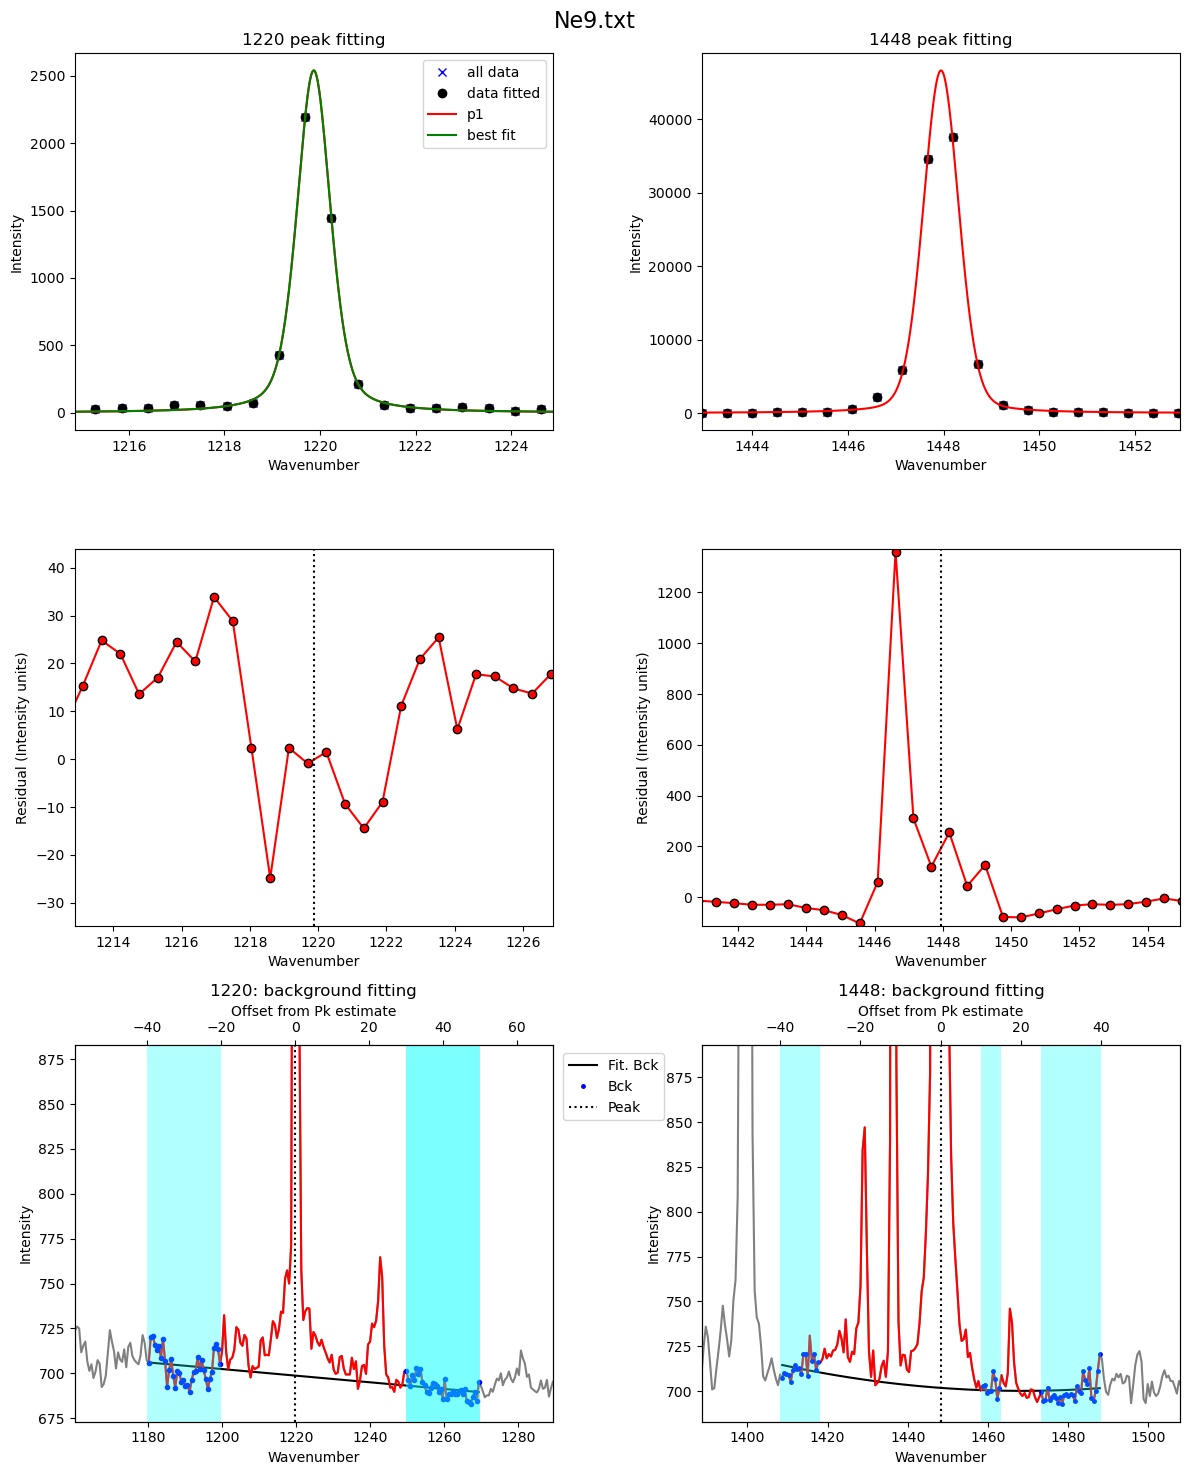

In [25]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [26]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0    Ne1.txt  0.997316    0.000020  228.069261    1447.911807    1219.842547   
1   Ne10.txt  0.997258    0.000017  228.082550    1447.972051    1219.889501   
2   Ne11.txt  0.997258    0.000018  228.082572    1447.976910    1219.894337   
3   Ne12.txt  0.997265    0.000017  228.081070    1447.981288    1219.900217   
4   Ne13.txt  0.997243    0.000018  228.085930    1447.982511    1219.896580   
5   Ne14.txt  0.997277    0.000018  228.078106    1447.980679    1219.902573   
6   Ne15.txt  0.997252    0.000017  228.083999    1447.982715    1219.898715   
7   Ne16.txt  0.997250    0.000019  228.084337    1447.983647    1219.899310   
8   Ne17.txt  0.997238    0.000019  228.087223    1447.984591    1219.897368   
9   Ne18.txt  0.997229    0.000017  228.089284    1447.982499    1219.893215   
10  Ne19.txt  0.997216    0.000019  228.092078    1447.981355    1219.889277   
11   Ne2.txt  0.997292    0.000021  228.074677    1447.922816    1219.848139   
12  Ne20.txt  0.997212    0.000019  228.093153    1447.982273    1219.889120   
13  Ne21.txt  0.997202    0.000018  228.095466    1447.986791    1219.891324   
14  Ne22.txt  0.997195    0.000026  228.096974    1447.986985    1219.890011   
15  Ne23.txt  0.997215    0.000018  228.092359    1447.983782    1219.891423   
16  Ne24.txt  0.997238    0.000019  228.087047    1447.980244    1219.893197   
17  Ne25.txt  0.997190    0.000018  228.098073    1447.984452    1219.886379   
18  Ne26.txt  0.997207    0.000018  228.094170    1447.984055    1219.889885   
19   Ne3.txt  0.997295    0.000021  228.074189    1447.928031    1219.853843   
20   Ne4.txt  0.997310    0.000021  228.070752    1447.933245    1219.862493   
21   Ne5.txt  0.997303    0.000021  228.072271    1447.934597    1219.862326   
22   Ne6.txt  0.997295    0.000020  228.074086    1447.936210    1219.862124   
23   Ne7.txt  0.997301    0.000019  228.072778    1447.940433    1219.867656   
24   Ne8.txt  0.997296    0.000019  228.073884    1447.943662    1219.869778   
25   Ne9.txt  0.997286    0.000019  228.076228    1447.946070    1219.869842   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  ...  pk2_gamma  \
0    46962.378367    2707.160966     85.201464     16.168624  ...       None   
1    49993.446529    2627.545831    109.104890     14.271900  ...       None   
2    50312.583305    2689.722760    111.544623     14.251987  ...       None   
3    51054.637297    2756.919067    114.857667     14.246035  ...       None   
4    50345.984125    2745.899680    114.855346     14.540132  ...       None   
5    50145.780374    2707.844319    109.745341     15.093619  ...       None   
6    49699.064542    2694.155969    111.782761     14.446308  ...       None   
7    51079.698467    2743.711503    113.336869     15.651509  ...       None   
8    49650.117384    2659.447678    109.234204     14.423679  ...       None   
9    49433.603986    2670.048289    103.875798     13.266752  ...       None   
10   48382.617499    2657.814652    109.446002     14.910292  ...       None   
11   46463.183323    2670.026878     98.158312     15.500622  ...       None   
12   48683.373897    2719.439536    111.201259     15.353215  ...       None   
13   48499.897560    2688.885826    108.935425     14.356800  ...       None   
14   49856.825345    2677.241552    104.745939     14.688245  ...       None   
15   48796.694250    2720.201067    105.750713     14.762681  ...       None   
16   47324.026280    2569.411401    102.116990     13.998898  ...       None   
17   48267.387800    2644.791365    111.690575     13.500343  ...       None   
18   48723.131546    2612.797819    108.847716     15.257915  ...       None   
19   46609.097102    2689.918298    100.070776     15.234233  ...       None   
20   46796.819487    2673.285159     92.015529     15.425205  ...       None   
21   46771.734308    2670.398587     88.325041     15.604424  ...       None   
22 

## Now extract metadata to get a timestamp for each file

In [27]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['Ne1.txt', 'Ne10.txt', 'Ne11.txt', 'Ne12.txt', 'Ne13.txt']

In [28]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

Done


filename            date Month  Day  power (mW)  Int_time (s)  \
0   Ne1.txt  June 7, 2023\n  June  7.0      35.213          45.0   
11  Ne2.txt  June 7, 2023\n  June  7.0      34.583          45.0   
19  Ne3.txt  June 7, 2023\n  June  7.0      34.546          45.0   
20  Ne4.txt  June 7, 2023\n  June  7.0      34.452          45.0   
21  Ne5.txt  June 7, 2023\n  June  7.0      34.375          45.0   

    accumulations  Mag (X)             duration      24hr_time  \
0             3.0      5.0  ['0h', '2m', '17s']  11:37:08 AM\n   
11            3.0      5.0  ['0h', '2m', '16s']  11:51:08 AM\n   
19            3.0      5.0  ['0h', '2m', '16s']  11:55:42 AM\n   
20            3.0      5.0  ['0h', '2m', '16s']  12:01:18 PM\n   
21            3.0      5.0  ['0h', '2m', '16s']  12:04:44 PM\n   

    sec since midnight  Spectral Center  
0              41828.0         1325.004  
11             42668.0         1325.004  
19             42942.0         1325.004  
20             43278.0         1325.004  
21             43484.0         1325.004

In [29]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8', 'Ne9',
       'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16', 'Ne17',
       'Ne18', 'Ne19', 'Ne20', 'Ne21', 'Ne22', 'Ne23', 'Ne24', 'Ne25',
       'Ne26'], dtype=object)

In [30]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne1', 'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16',
       'Ne17', 'Ne18', 'Ne19', 'Ne2', 'Ne20', 'Ne21', 'Ne22', 'Ne23',
       'Ne24', 'Ne25', 'Ne26', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7', 'Ne8',
       'Ne9'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [31]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [32]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

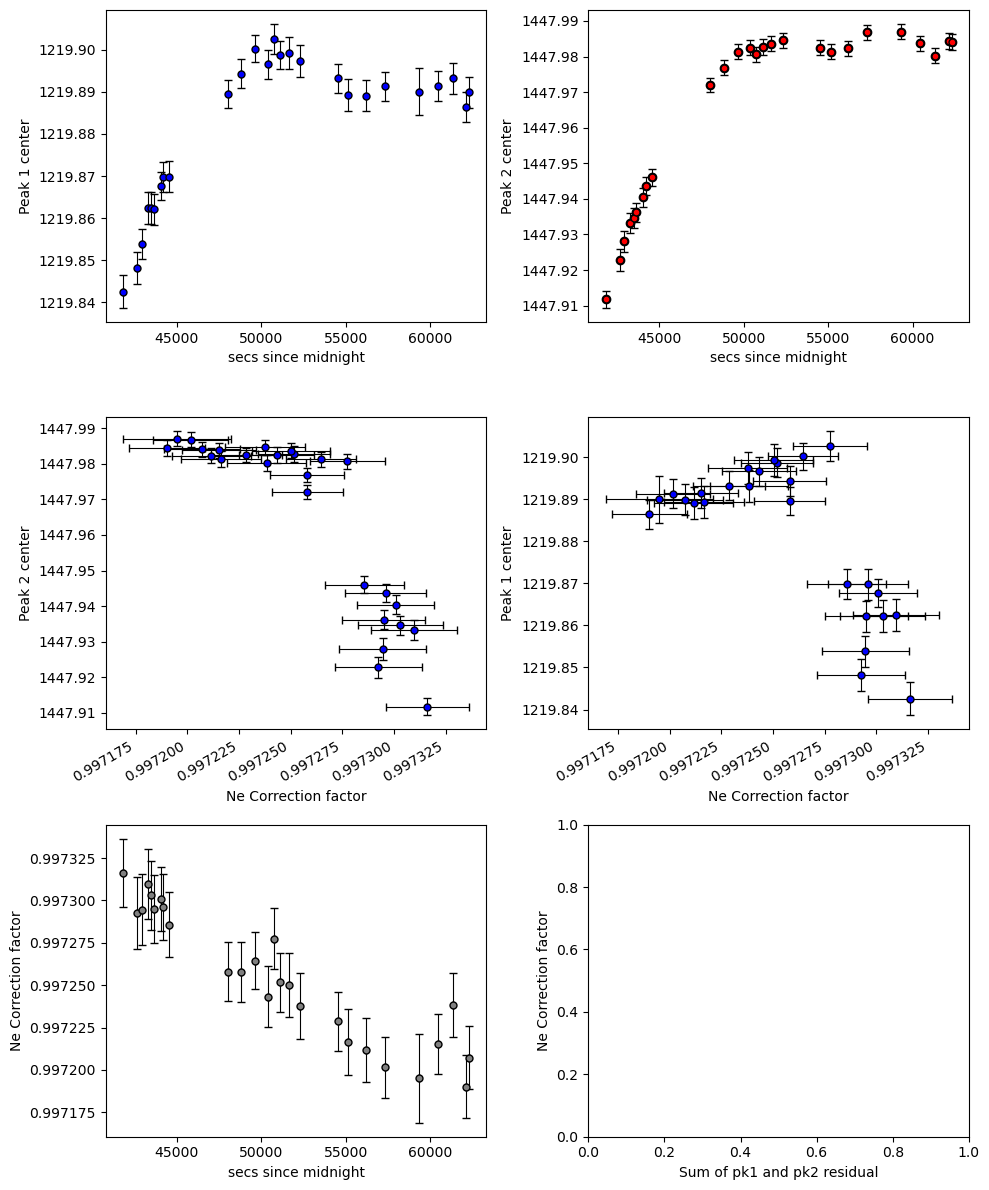

In [33]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

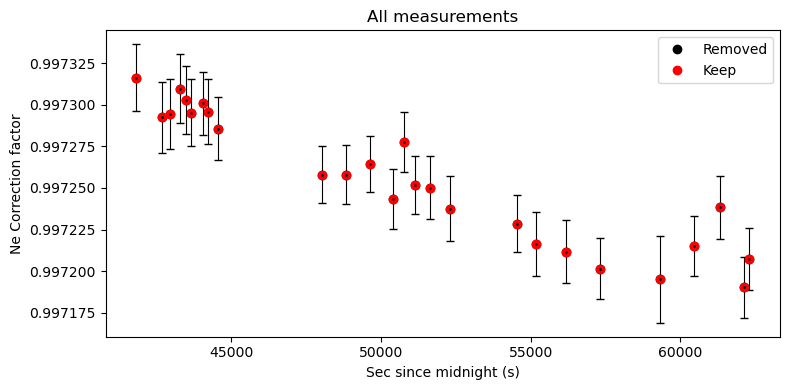

In [34]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

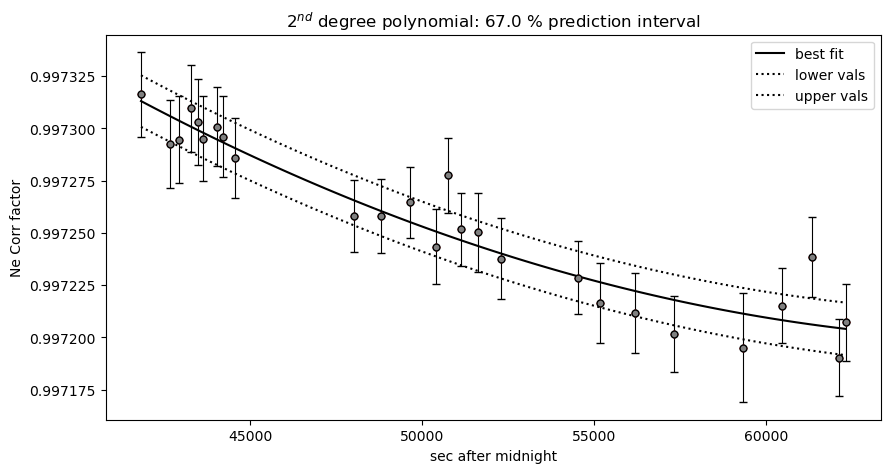

In [36]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model_1220_1147.pkl')
